In [1]:
#pip install py7zr

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import numpy as np
import py7zr
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = [15.0, 10.0]
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'

In [4]:
interpolated_data = pd.read_csv('interpolated_data_tl1.csv', low_memory = False)

In [5]:
df = interpolated_data.copy()
df['time'] = pd.to_datetime(df['time'])
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051201 entries, 0 to 1051200
Columns: 154 entries, time to Скважина ЛА-506: Давление забойное, barg
dtypes: datetime64[ns](1), float64(119), object(34)
memory usage: 1.2+ GB


time Платформа: Температура окружающей среды, degC  \
0 2022-08-01 00:00:00                                      13.56105   
1 2022-08-01 00:00:30                                      13.57446   
2 2022-08-01 00:01:00                                      13.58788   
3 2022-08-01 00:01:30                                      13.60461   
4 2022-08-01 00:02:00                                      13.62154   
5 2022-08-01 00:02:30                                      13.63938   
6 2022-08-01 00:03:00                                      13.65722   
7 2022-08-01 00:03:30                                      13.67319   
8 2022-08-01 00:04:00                                      13.68915   
9 2022-08-01 00:04:30                                      13.70383   

   ТЛ1 Сепаратор : Расход по газу, kSm3/h  \
0                                1050.821   
1                                1050.176   
2                                1050.351   
3                                1050.908   
4                                1046.780   
5                                1046.071   
6                                1047.964   
7                                1049.856   
8                                1051.749   
9                                1047.011   

  ТЛ1 Сепаратор : Расход по конденсату, Sm3/h  \
0                                    37.12975   
1                                    37.56005   
2                                    37.03209   
3                                    37.16535   
4                                    36.90152   
5                                    33.61278   
6                                    28.98388   
7                                    26.82405   
8                                    26.03109   
9                                    25.30749   

   ТЛ1 Сепаратор : Расход по воде  , m3/h  \
0                                0.188499   
1                                0.188499   
2                                0.188499   
3                                2.345471   
4                                3.685060   
5                                3.615524   
6                                3.570450   
7                                3.559652   
8                                3.617787   
9                                1.394205   

   ТЛ1 Сепаратор : Температура на выходе газа, degC  \
0                                          59.42110   
1                                          59.42216   
2                                          59.42322   
3                                          59.42428   
4                                          59.42533   
5                                          59.42640   
6                                          59.42745   
7                                          59.42851   
8                                          59.42957   
9                                          59.43063   

   ТЛ1 Сепаратор : Температура на выходе конденсата, degC  \
0                                           59.61190        
1                                           59.61227        
2                                           59.61264        
3                                           59.61302        
4                                           59.61340        
5                                           59.61377        
6                                           59.61415        
7                                           59.61452        
8                                           59.61489        
9                                           59.61527        

   ТЛ1 Сепаратор : Давление на выходе газа, barg  \
0                                       94.68169   
1                                       94.68456   
2                                       94.68744   
3                                       94.69032   
4                                       94.69319   
5                                       94.69607   
6                                       94.69894   
7        

=========================================================================================================================

In [6]:
#len(gh

In [7]:
dictionary = {'one':1, 'two':2}
[x for x in dictionary.values()]

[1, 2]

# Функции для предобработки

In [8]:
# Функция для поиска слов в строковом объекте

def word_search(x, pattern):
    list_words = pattern.findall(x)
    if len(list_words) != 0:
        return True
    else:
        return False

In [9]:
# Функция для подсчёта количества слов в колонке датафрейма

def count_words(column, pattern):
    count = 0
    for x in column:
        list_words = pattern.findall(x)
        if len(list_words) != 0:
            count += 1
    return print(count)

In [10]:
# Функция для поиска и извлечения слов в колонке датафрейма

def extract_words(column, pattern):
    index_values = {}
    for i, x in enumerate(column):
        list_words = pattern.findall(x)
        if len(list_words) != 0:
            word = list_words[0]
            index_values[i] = word
    return index_values

In [11]:
# Функция для преобразования в столбцах датафрейма строкового типа данных в числовой и замены нечисловых значений 
# на числа методом линейной интерполяции

def feature_processing(df, pattern):
    for column in df.columns[1:]:
        df[column] = df[column].apply(lambda x: float(str(x)) if len(pattern.findall(str(x))) == 0 else None)
        df[column] = df[column].interpolate(method = 'linear')

In [12]:
# Валидация и визуализация предсказанных значений расхода по газу на всех скважинах

def validation_visualize(dataframe, list_columns, model):
    
    dataframe['Суммарный предсказанный расход по газу, ksm3/h'] = np.zeros(len(dataframe))
    dataframe_modified = dataframe.drop(['time', 'Суммарный предсказанный расход по газу, ksm3/h'], axis = 1)
    
    list_convs = []
    
    for i in range(10, dataframe_modified.shape[1], 13):
        dataframe_test = pd.DataFrame(np.hstack([dataframe_modified.iloc[:, :10], dataframe_modified.iloc[:, i:i + 13]]), 
                                      columns = list_columns)
        X_array_test = dataframe_test.drop('Скважина: Расход по газу Вентури, ksm3/h', axis = 1)
        y_array_test = dataframe_test['Скважина: Расход по газу Вентури, ksm3/h'].values
        
        # Нормализация
        X_array_test = scaler.transform(X_array_test)
        
        # Предсказание
        y_array_pred = model.predict(X_array_test)
        dataframe['Суммарный предсказанный расход по газу, ksm3/h'] += y_array_pred
        
        convergence = round((1 - abs(y_array_test - y_array_pred).mean()/y_array_test.mean())*100, 2)
        list_convs.append(convergence)
        
        plt.figure(figsize = (15, 10))
        plt.plot(dataframe['time'].values, y_array_test)
        plt.plot(dataframe['time'].values, y_array_pred)
        #plt.xlim([datetime.strptime('2023-06-05 12:00:00', '%Y-%m-%d %H:%M:%S'), \
        #          datetime.strptime('2023-06-05 15:00:00', '%Y-%m-%d %H:%M:%S')])
        plt.ylim(-50, 250)
        plt.xticks(rotation = 45)
        plt.legend(['Расход по газу Вентури, ksm3/h', 'Предсказанный расход по газу, ksm3/h'])
        plt.title(dataframe_modified.columns[i][:17] + ' расход по газу, ksm3/h; ' + f'Сходимость: {convergence} %; ' + \
                  f'MAE = {round(mean_absolute_error(y_array_test, y_array_pred), 2)}')
        plt.xlabel('Дата')
        plt.ylabel(dataframe_modified.columns[i][:17] + ' расход по газу, ksm3/h')
        plt.grid()
        
    convergence_sum = round((1 - abs(dataframe.iloc[:, 2].values - dataframe['Суммарный предсказанный расход по газу, ksm3/h'].values).mean()/dataframe.iloc[:, 2].values.mean())*100, 2)
        
    # Вывод графиков суммарного предсказанного расхода по газу и расхода по газу на сепараторе
    plt.figure(figsize = (15, 10))
    plt.plot(dataframe['time'].values, dataframe.iloc[:, 2])
    plt.plot(dataframe['time'].values, dataframe['Суммарный предсказанный расход по газу, ksm3/h'])
    plt.xticks(rotation = 45)
    plt.legend([dataframe.columns[2], 'Суммарный предсказанный расход по газу, ksm3/h'])
    plt.title('Суммарный расход по газу, ksm3/h; ' + f'Сходимость: {convergence_sum} %')
    plt.xlabel('Дата')
    plt.ylabel('Расход по газу, ksm3/h')
    plt.grid()
        
    print('Средняя сходимость по всем скважинам: ', round(sum(list_convs)/len(list_convs), 2), '%')
    print('Минимальная сходимость: ', round(min(list_convs), 2), '%')

=========================================================================================================================

# Разведывательный анализ данных (EDA)

In [13]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051201 entries, 0 to 1051200
Data columns (total 154 columns):
 #    Column                                                               Dtype         
---   ------                                                               -----         
 0    time                                                                 datetime64[ns]
 1    Платформа: Температура окружающей среды, degC                        object        
 2    ТЛ1 Сепаратор : Расход по газу, kSm3/h                               float64       
 3    ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                          object        
 4    ТЛ1 Сепаратор : Расход по воде  , m3/h                               float64       
 5    ТЛ1 Сепаратор : Температура на выходе газа, degC                     float64       
 6    ТЛ1 Сепаратор : Температура на выходе конденсата, degC               float64       
 7    ТЛ1 Сепаратор : Давление на выходе газа, barg                        f

In [14]:
df.isna().sum()[:20]

time                                                                   0
Платформа: Температура окружающей среды, degC                          0
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                 0
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                            0
ТЛ1 Сепаратор : Расход по воде  , m3/h                                 0
ТЛ1 Сепаратор : Температура на выходе газа, degC                       0
ТЛ1 Сепаратор : Температура на выходе конденсата, degC                 0
ТЛ1 Сепаратор : Давление на выходе газа, barg                          0
ТЛ1 Сепаратор : Давление на выходе конденсата, barg                    0
ТЛ1 Манифольд : Давление, barg                                         0
ТЛ1 Манифольд : Температура, degC                                      0
Скважина ЛА-529 : Процент открытия штуцера, %                          0
Скважина ЛА-529: Расход по газу Вентури, ksm3/h                        0
Скважина ЛА-529: Расход по конденсату Вентури, sm3/

## 1. Платформа Температура окружающей среды, degC

Смотрим есть ли слова в столбце **Платформа Температура окружающей среды, degC** и считаем их количество.

In [15]:
pattern = re.compile('[A-Za-z]+')

In [16]:
count_words(df['Платформа: Температура окружающей среды, degC'], pattern)

696


Найдено 696 слов. Заменим слова пропущенными значениями, чтобы затем заполнить пропуски числами методом линейной интерполяции. Сразу применим этот метод ко всем столбцам датафрейма.

In [17]:
extract_words(df['Платформа: Температура окружающей среды, degC'], pattern)

{4141: 'Bad',
 4142: 'Bad',
 4143: 'Bad',
 4144: 'Bad',
 4145: 'Bad',
 4146: 'Bad',
 4147: 'Bad',
 4148: 'Bad',
 7435: 'Bad',
 7436: 'Bad',
 283753: 'Bad',
 283754: 'Bad',
 283755: 'Bad',
 283756: 'Bad',
 283757: 'Bad',
 283758: 'Bad',
 283759: 'Bad',
 283760: 'Bad',
 283761: 'Bad',
 283762: 'Bad',
 283763: 'Bad',
 283764: 'Bad',
 283765: 'Bad',
 283766: 'Bad',
 283767: 'Bad',
 283768: 'Bad',
 283769: 'Bad',
 283770: 'Bad',
 283771: 'Bad',
 283772: 'Bad',
 283773: 'Bad',
 283774: 'Bad',
 283775: 'Bad',
 283776: 'Bad',
 283777: 'Bad',
 283778: 'Bad',
 283779: 'Bad',
 283780: 'Bad',
 283781: 'Bad',
 283782: 'Bad',
 283783: 'Bad',
 283784: 'Bad',
 283785: 'Bad',
 283786: 'Bad',
 283787: 'Bad',
 283788: 'Bad',
 283789: 'Bad',
 283790: 'Bad',
 283791: 'Bad',
 283792: 'Bad',
 283793: 'Bad',
 283794: 'Bad',
 283795: 'Bad',
 283796: 'Bad',
 283797: 'Bad',
 283798: 'Bad',
 283799: 'Bad',
 283800: 'Bad',
 283801: 'Bad',
 283802: 'Bad',
 283803: 'Bad',
 283804: 'Bad',
 283805: 'Bad',
 283806: 'Ba

In [18]:
# Время работы кода 7 мин.

feature_processing(df, pattern)

In [19]:
#len(gh

In [20]:
'''
df['Платформа: Температура окружающей среды, degC'] = \
df['Платформа: Температура окружающей среды, degC'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                            pattern = pattern) == False \
                                                          else None)

df['Платформа: Температура окружающей среды, degC'].isna().sum()
'''

"\ndf['Платформа: Температура окружающей среды, degC'] = df['Платформа: Температура окружающей среды, degC'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                            pattern = pattern) == False                                                           else None)\n\ndf['Платформа: Температура окружающей среды, degC'].isna().sum()\n"

In [21]:
#df[df['Платформа: Температура окружающей среды, degC'].isna()].head(3)

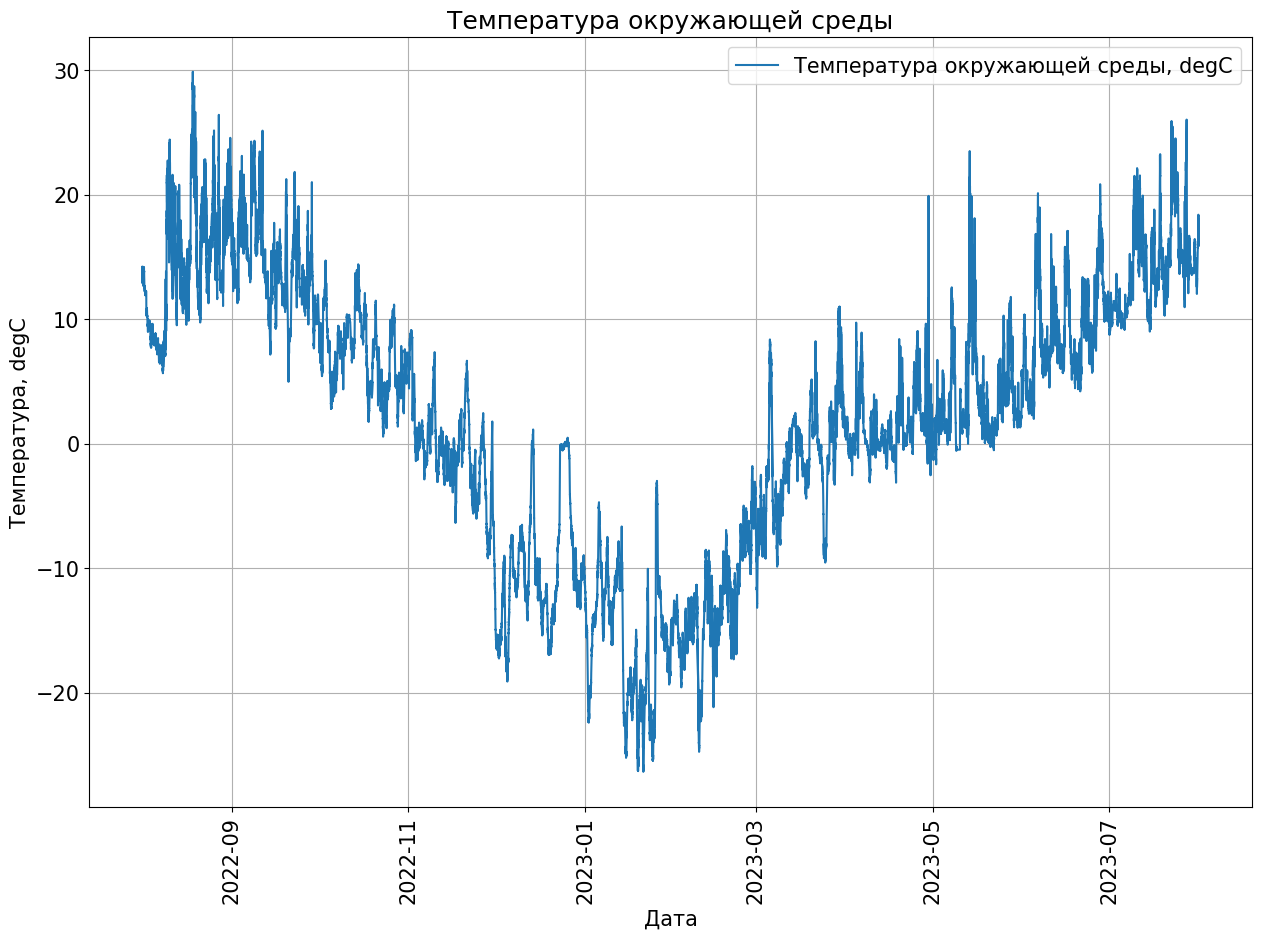

In [22]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Платформа: Температура окружающей среды, degC'])
#plt.xlim([datetime.strptime('2022-08-02 00:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2022-08-03 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['Температура окружающей среды, degC'])
plt.title('Температура окружающей среды')
plt.xlabel('Дата')
plt.ylabel('Температура, degC')
plt.grid()

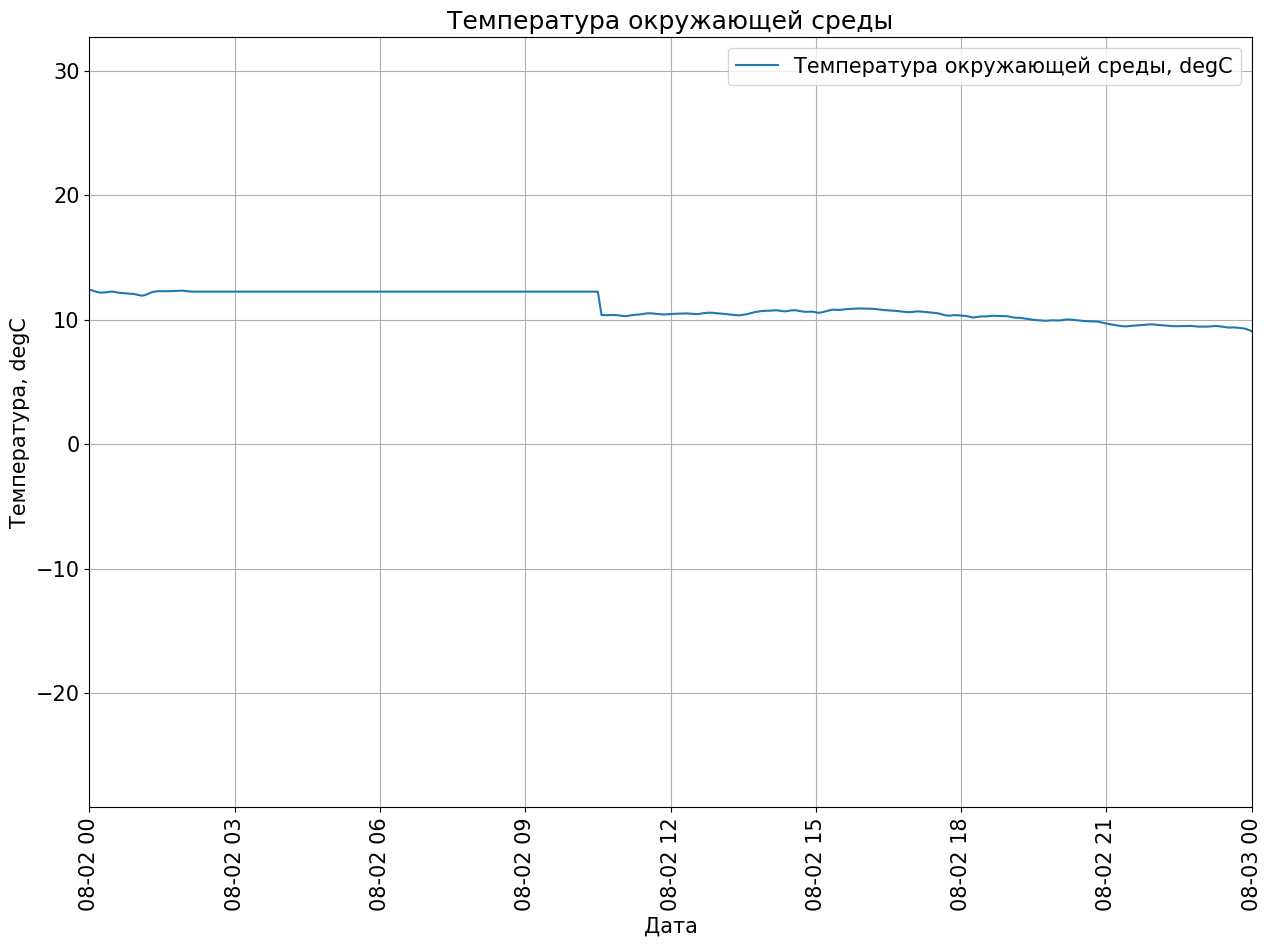

In [23]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Платформа: Температура окружающей среды, degC'])
plt.xlim([datetime.strptime('2022-08-02 00:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2022-08-03 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['Температура окружающей среды, degC'])
plt.title('Температура окружающей среды')
plt.xlabel('Дата')
plt.ylabel('Температура, degC')
plt.grid()

Применим линейную интерполяцию для того, чтобы заполнить пропуски в столбце **Платформа: Температура окружающей среды, degC**.

In [24]:
#df['Платформа: Температура окружающей среды, degC'] = \
#df['Платформа: Температура окружающей среды, degC'].interpolate(method = 'linear')

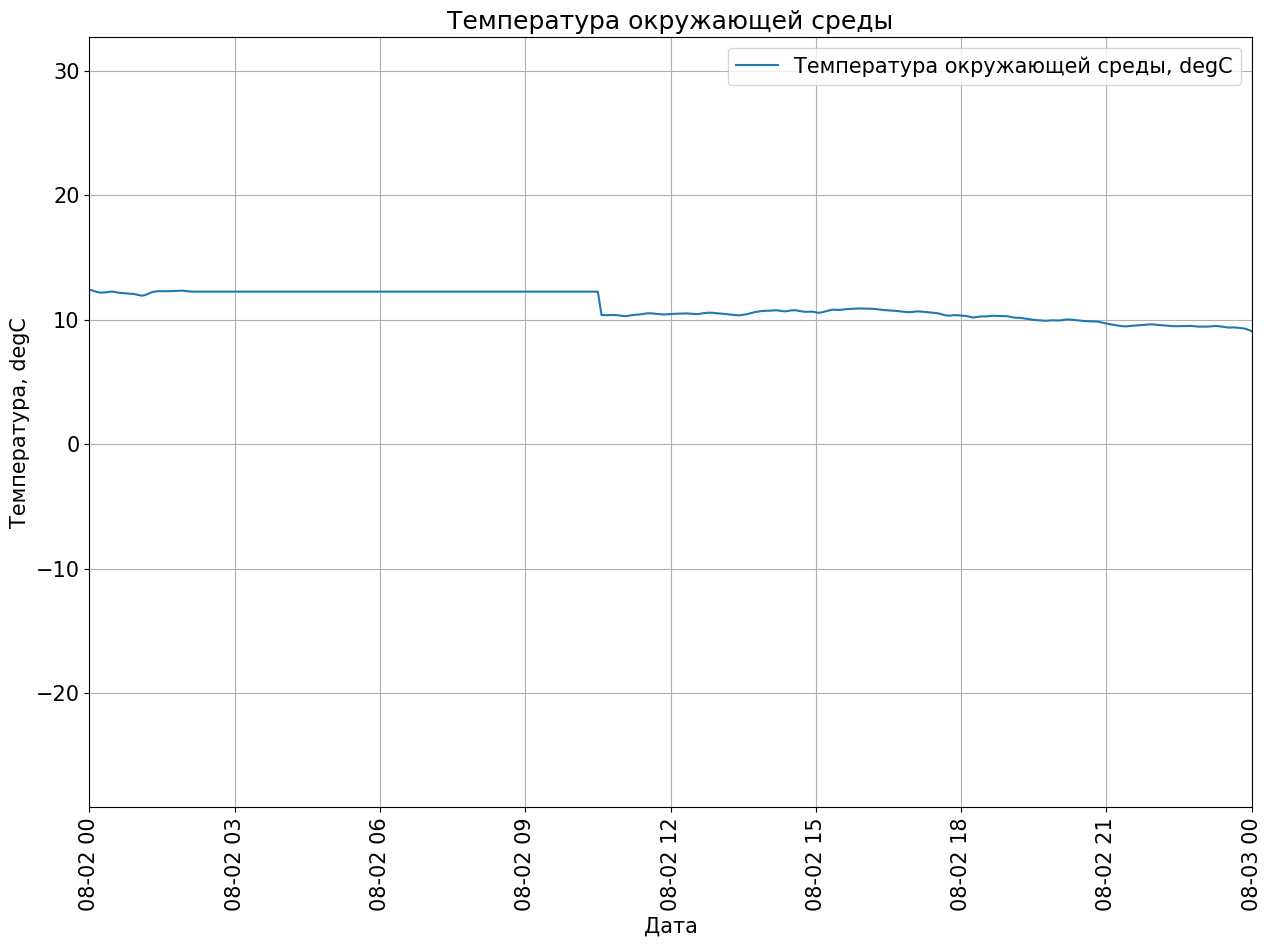

In [25]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Платформа: Температура окружающей среды, degC'])
plt.xlim([datetime.strptime('2022-08-02 00:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2022-08-03 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['Температура окружающей среды, degC'])
plt.title('Температура окружающей среды')
plt.xlabel('Дата')
plt.ylabel('Температура, degC')
plt.grid()

# Сепаратор

## 2. ТЛ1 Сепаратор  Расход по газу, kSm3/h

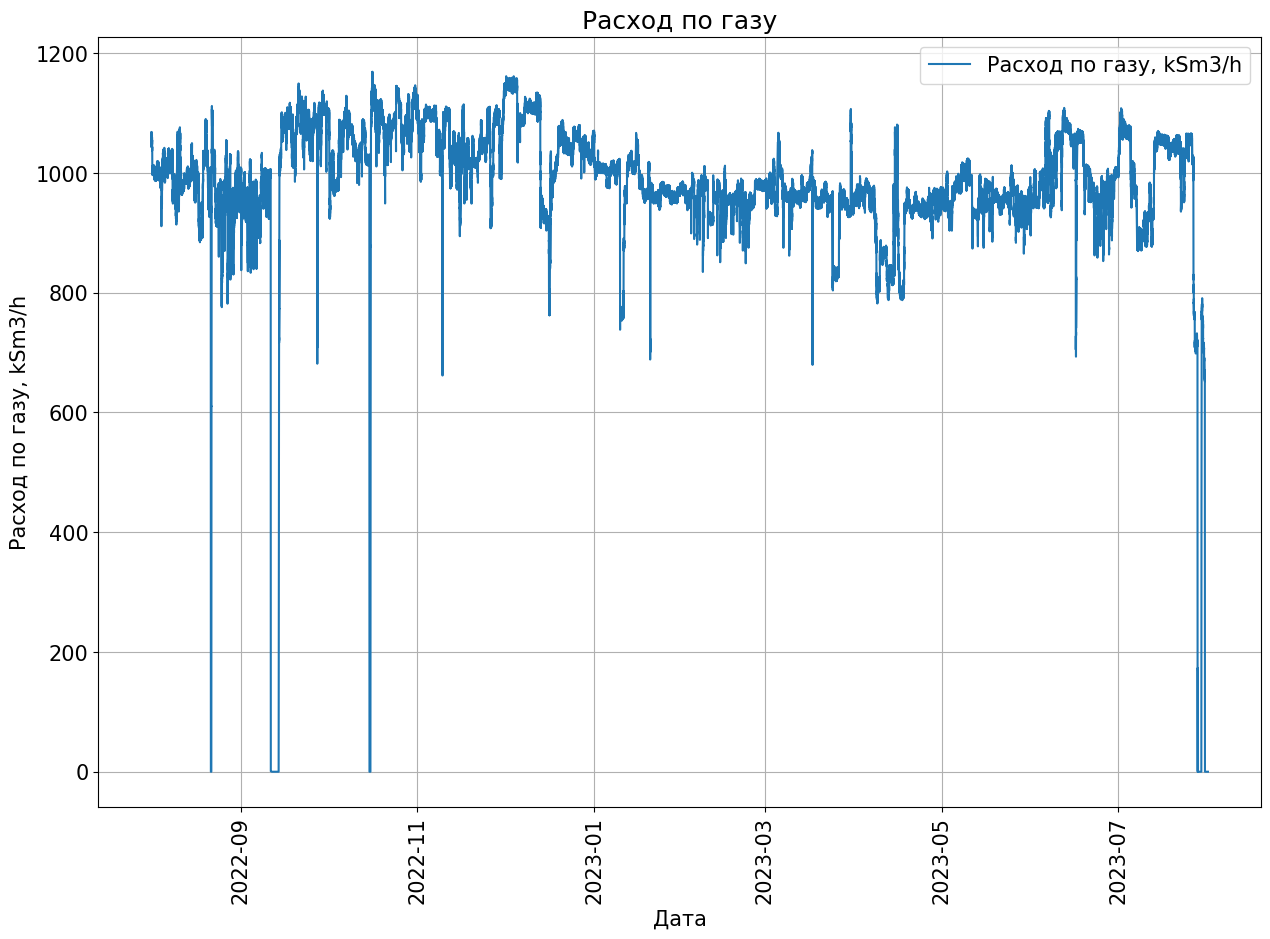

In [26]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['ТЛ1 Сепаратор : Расход по газу, kSm3/h'])
#plt.xlim([datetime.strptime('2022-08-02 00:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2022-08-03 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['Расход по газу, kSm3/h'])
plt.title('Расход по газу')
plt.xlabel('Дата')
plt.ylabel('Расход по газу, kSm3/h')
plt.grid()

## 3. ТЛ1 Сепаратор  Расход по конденсату, Sm3/h

In [27]:
#count_words(df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'], pattern)

In [28]:
'''
df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'] = \
df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                          pattern = pattern) == False \
                                                        else None)

df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].isna().sum()
'''

"\ndf['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'] = df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                          pattern = pattern) == False                                                         else None)\n\ndf['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].isna().sum()\n"

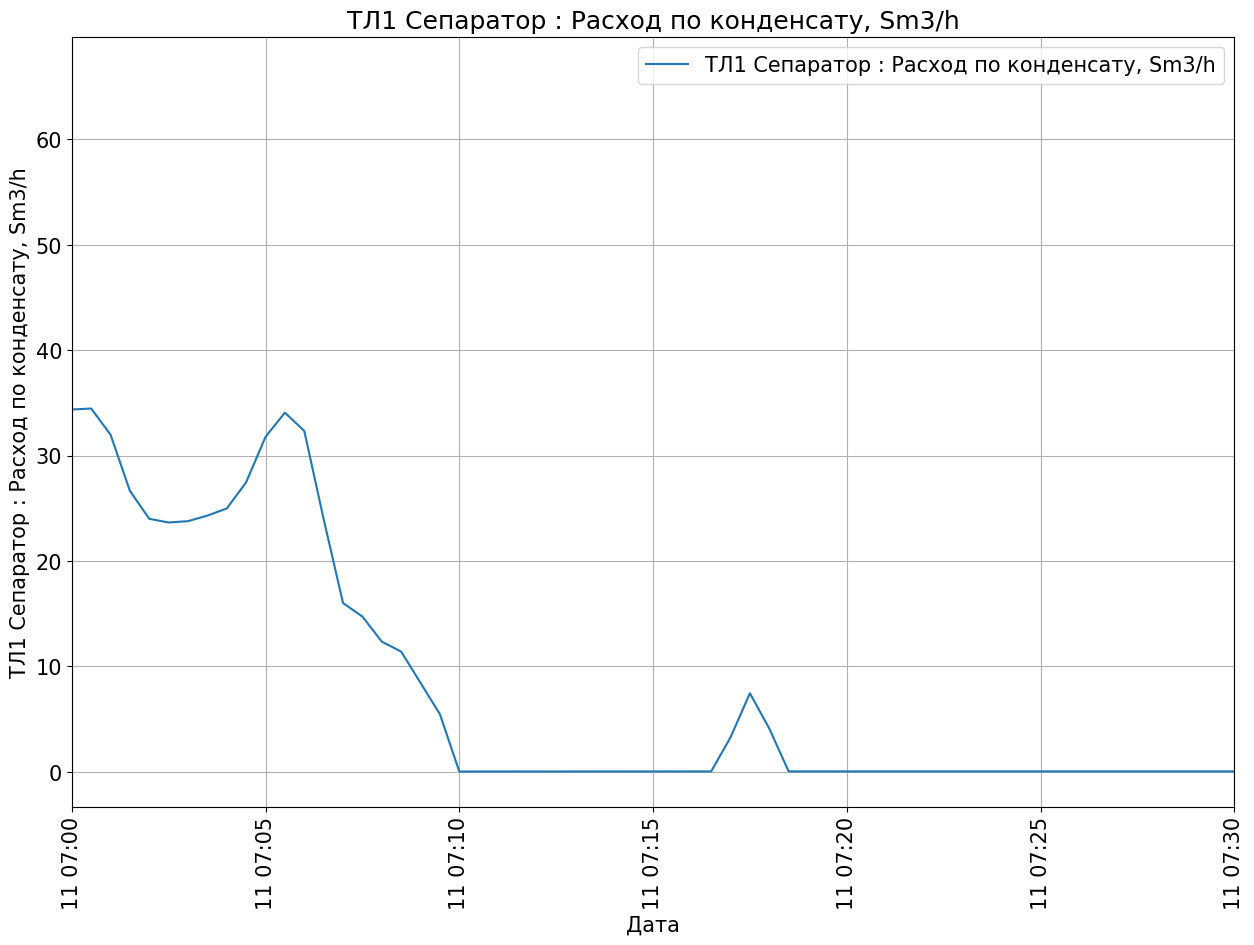

In [29]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'])
plt.xlim([datetime.strptime('2022-09-11 07:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2022-09-11 07:30:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'])
plt.title('ТЛ1 Сепаратор : Расход по конденсату, Sm3/h')
plt.xlabel('Дата')
plt.ylabel('ТЛ1 Сепаратор : Расход по конденсату, Sm3/h')
plt.grid()

In [30]:
'''
df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'] = \
df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].interpolate(method = 'linear')

df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].isna().sum()
'''

"\ndf['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'] = df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].interpolate(method = 'linear')\n\ndf['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'].isna().sum()\n"

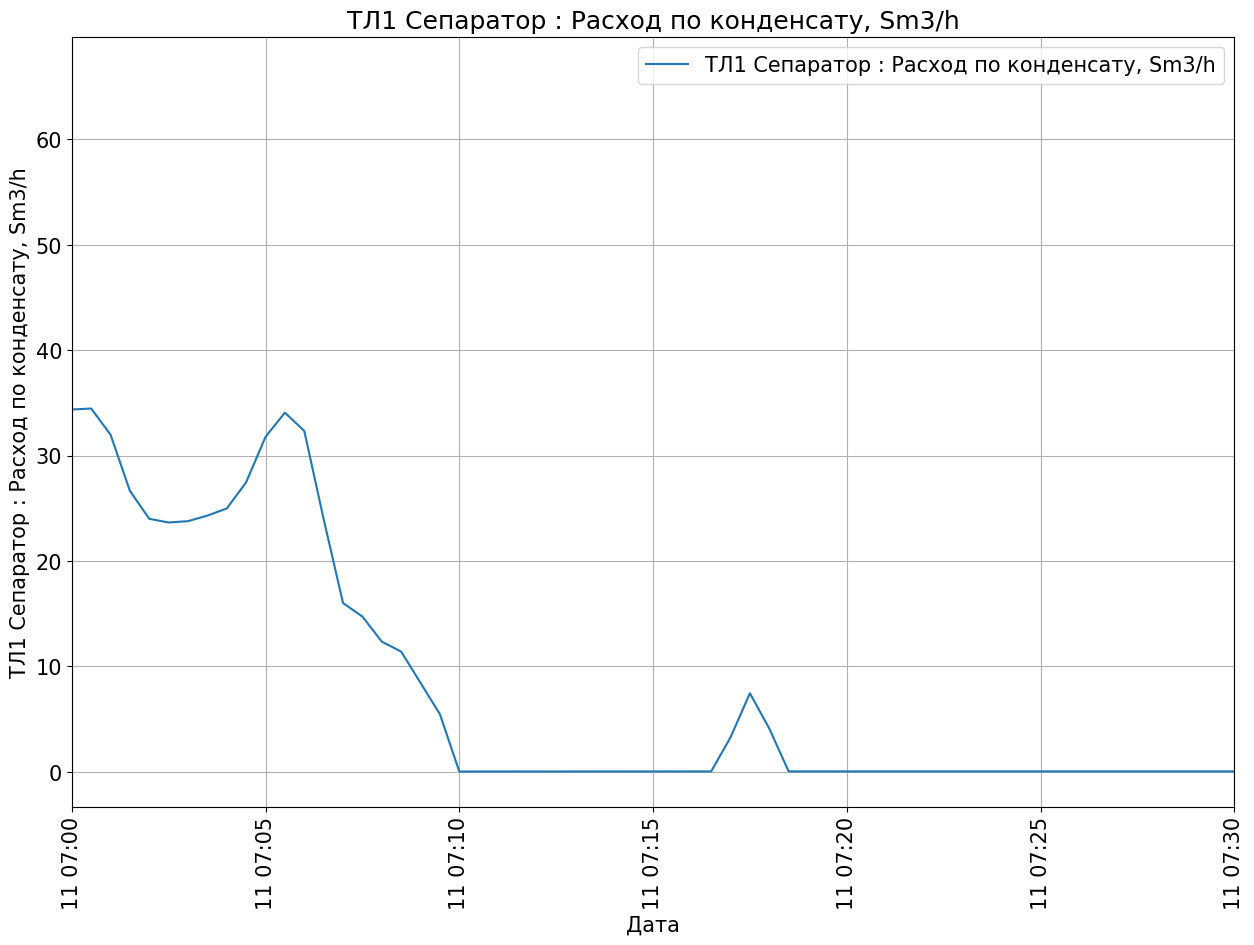

In [31]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'])
plt.xlim([datetime.strptime('2022-09-11 07:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2022-09-11 07:30:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['ТЛ1 Сепаратор : Расход по конденсату, Sm3/h'])
plt.title('ТЛ1 Сепаратор : Расход по конденсату, Sm3/h')
plt.xlabel('Дата')
plt.ylabel('ТЛ1 Сепаратор : Расход по конденсату, Sm3/h')
plt.grid()

## 4. ТЛ1 Сепаратор : Расход по воде  , m3/h

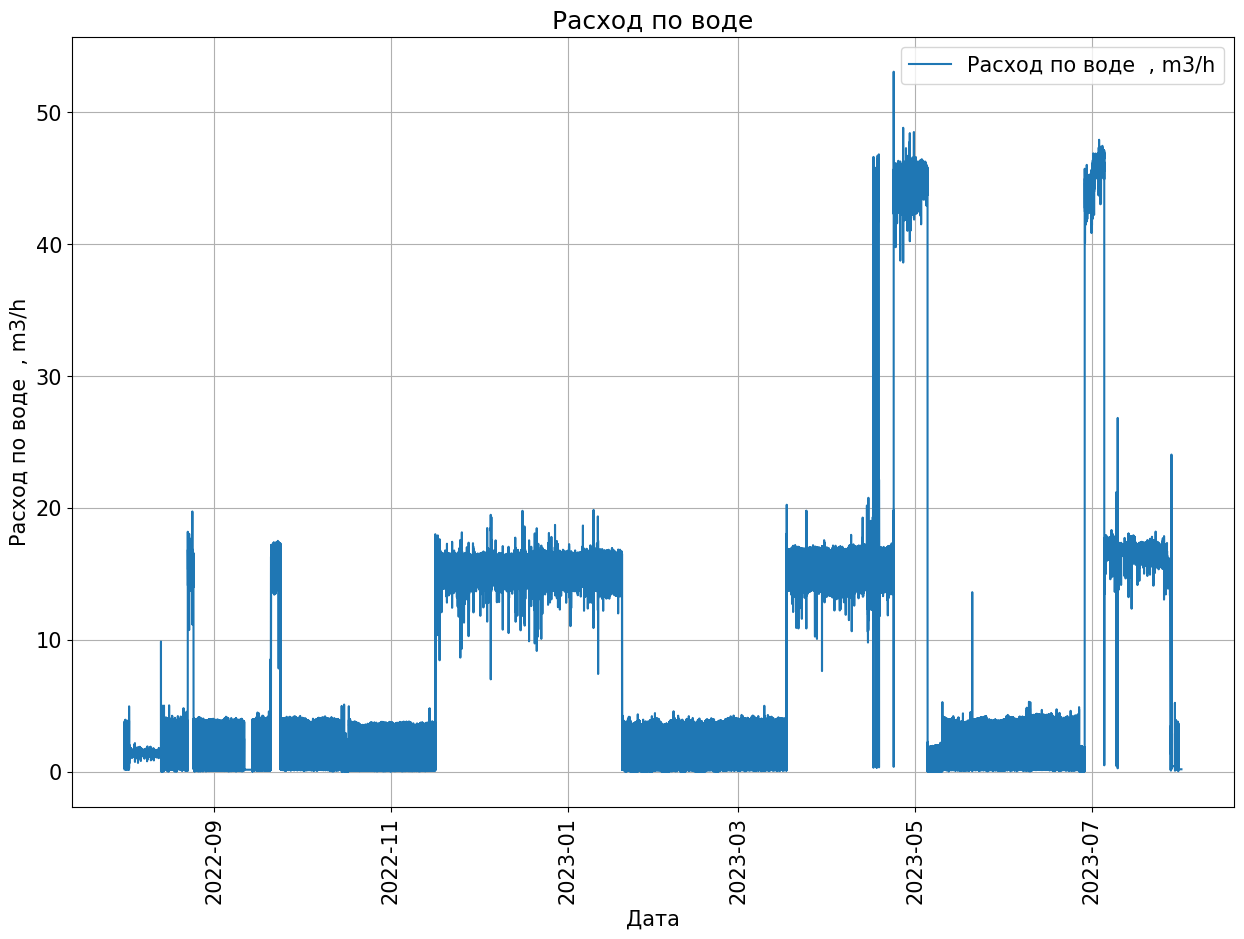

In [32]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['ТЛ1 Сепаратор : Расход по воде  , m3/h'])
#plt.xlim([datetime.strptime('2022-08-02 00:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2022-08-03 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
plt.legend(['Расход по воде  , m3/h'])
plt.title('Расход по воде')
plt.xlabel('Дата')
plt.ylabel('Расход по воде  , m3/h')
plt.grid()

## 5. ТЛ1 Сепаратор : Температура на выходе газа, degC

## 6. ТЛ1 Сепаратор : Температура на выходе конденсата, degC

## 7. ТЛ1 Сепаратор : Давление на выходе газа, barg

## 8. ТЛ1 Сепаратор : Давление на выходе конденсата, barg

# Манифольд

## 9. ТЛ1 Манифольд : Давление, barg

## 10. ТЛ1 Манифольд : Температура, degC

# Скважина ЛА-529

## 11. Скважина ЛА-529 : Процент открытия штуцера, %

In [33]:
#count_words(df['Скважина ЛА-529 : Процент открытия штуцера, %'], pattern)

In [34]:
'''
df['Скважина ЛА-529 : Процент открытия штуцера, %'] = \
df['Скважина ЛА-529 : Процент открытия штуцера, %'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                            pattern = pattern) == False \
                                                          else None)

df['Скважина ЛА-529 : Процент открытия штуцера, %'].isna().sum()
'''

"\ndf['Скважина ЛА-529 : Процент открытия штуцера, %'] = df['Скважина ЛА-529 : Процент открытия штуцера, %'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                            pattern = pattern) == False                                                           else None)\n\ndf['Скважина ЛА-529 : Процент открытия штуцера, %'].isna().sum()\n"

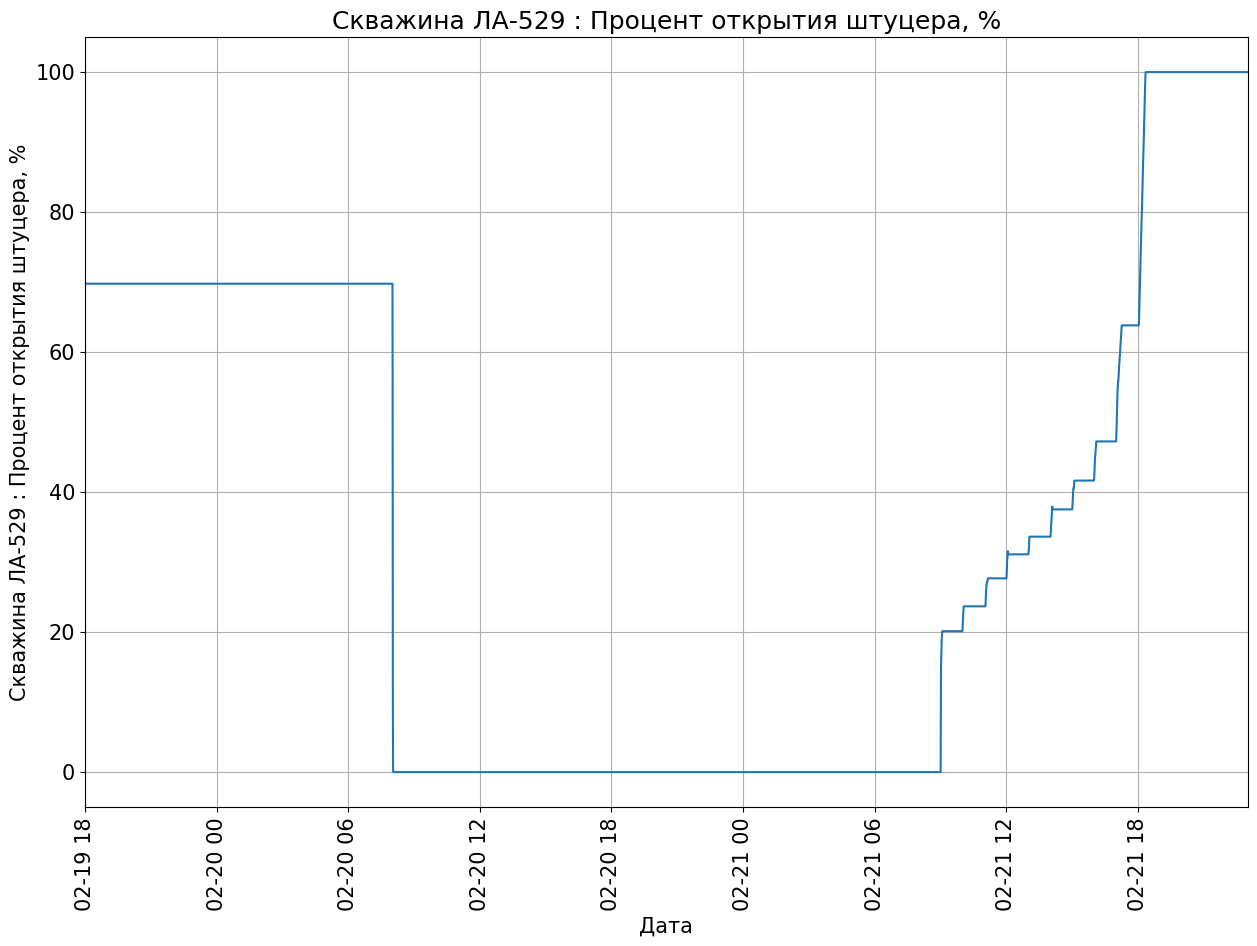

In [35]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-529 : Процент открытия штуцера, %'])
plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Скважина ЛА-529 : Процент открытия штуцера, %'])
plt.title('Скважина ЛА-529 : Процент открытия штуцера, %')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-529 : Процент открытия штуцера, %')
plt.grid()

In [36]:
'''
df['Скважина ЛА-529 : Процент открытия штуцера, %'] = \
df['Скважина ЛА-529 : Процент открытия штуцера, %'].interpolate(method = 'linear')

df['Скважина ЛА-529 : Процент открытия штуцера, %'].isna().sum()
'''

"\ndf['Скважина ЛА-529 : Процент открытия штуцера, %'] = df['Скважина ЛА-529 : Процент открытия штуцера, %'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-529 : Процент открытия штуцера, %'].isna().sum()\n"

## 12. Скважина ЛА-529: Расход по газу Вентури, ksm3/h

In [37]:
#count_words(df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'], pattern)

In [38]:
'''
df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

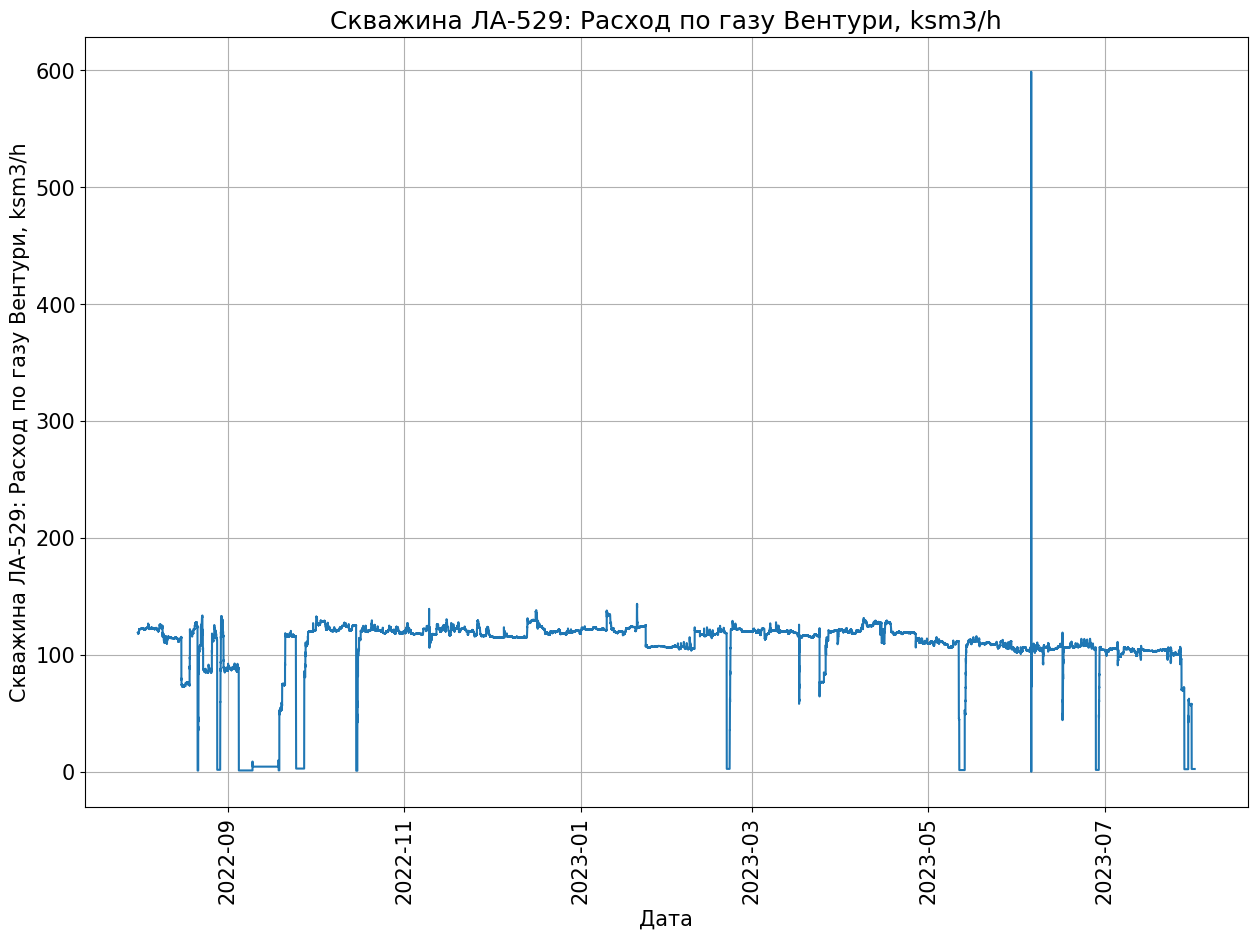

In [39]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'])
# plt.xlim([datetime.strptime('2023-07-31 23:00:00', '%Y-%m-%d %H:%M:%S'), \
#           datetime.strptime('2023-08-01 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'])
plt.title('Скважина ЛА-529: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-529: Расход по газу Вентури, ksm3/h')
plt.grid()

In [40]:
'''
df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-508

## 25. Скважина ЛА-508: Расход по газу Вентури, ksm3/h

In [41]:
#count_words(df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'], pattern)

In [42]:
'''
df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

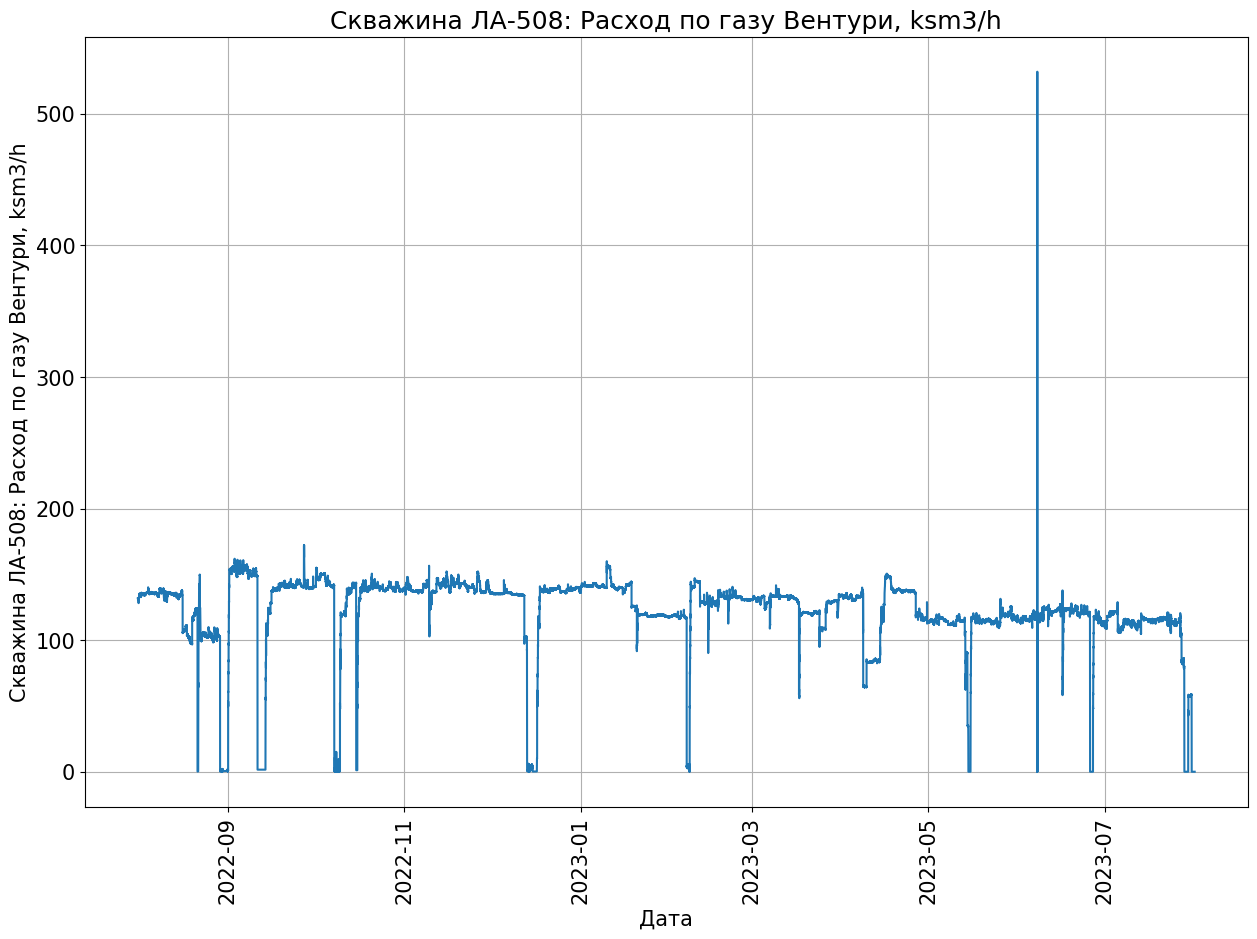

In [43]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-508: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-508: Расход по газу Вентури, ksm3/h')
plt.grid()

In [44]:
'''
df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-504

## 38. Скважина ЛА-504: Расход по газу Вентури, ksm3/h

In [45]:
#count_words(df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'], pattern)

In [46]:
'''
df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

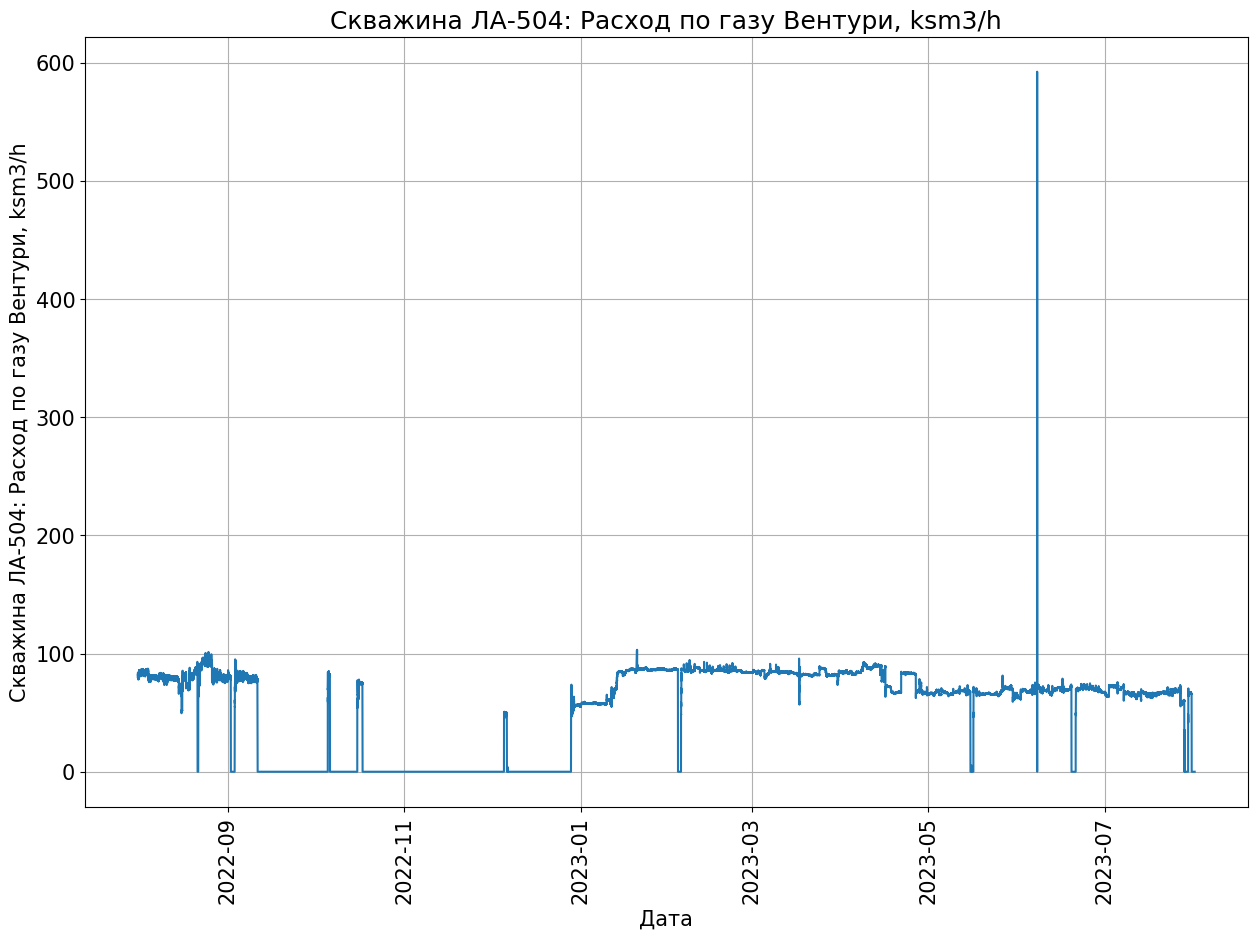

In [47]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-504: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-504: Расход по газу Вентури, ksm3/h')
plt.grid()

In [48]:
'''
df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-524

## 51. Скважина ЛА-524: Расход по газу Вентури, ksm3/h

In [49]:
#count_words(df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'], pattern)

In [50]:
'''
df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

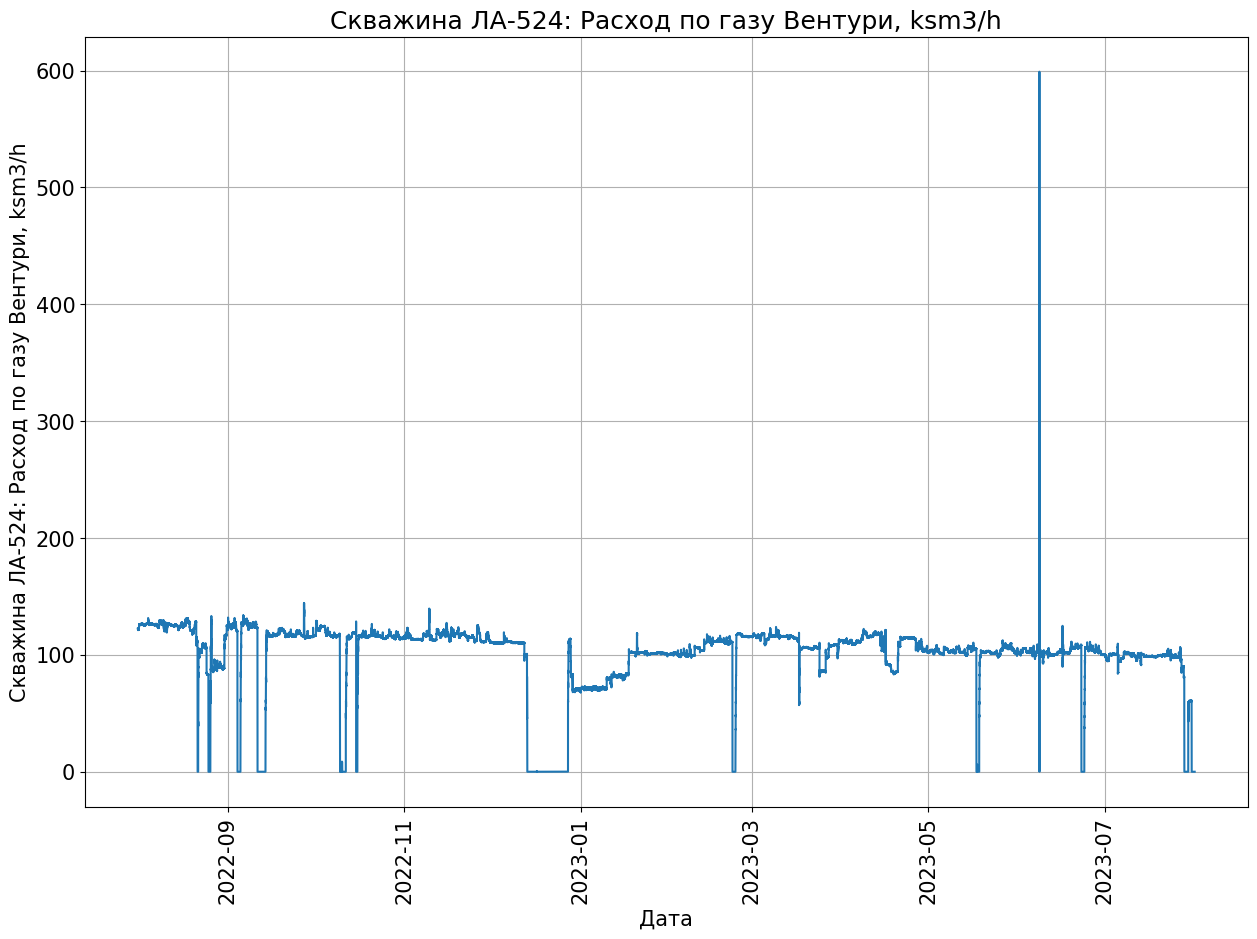

In [51]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-524: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-524: Расход по газу Вентури, ksm3/h')
plt.grid()

In [52]:
'''
df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-554

## 64. Скважина ЛА-554: Расход по газу Вентури, ksm3/h

In [53]:
#count_words(df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'], pattern)

In [54]:
'''
df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

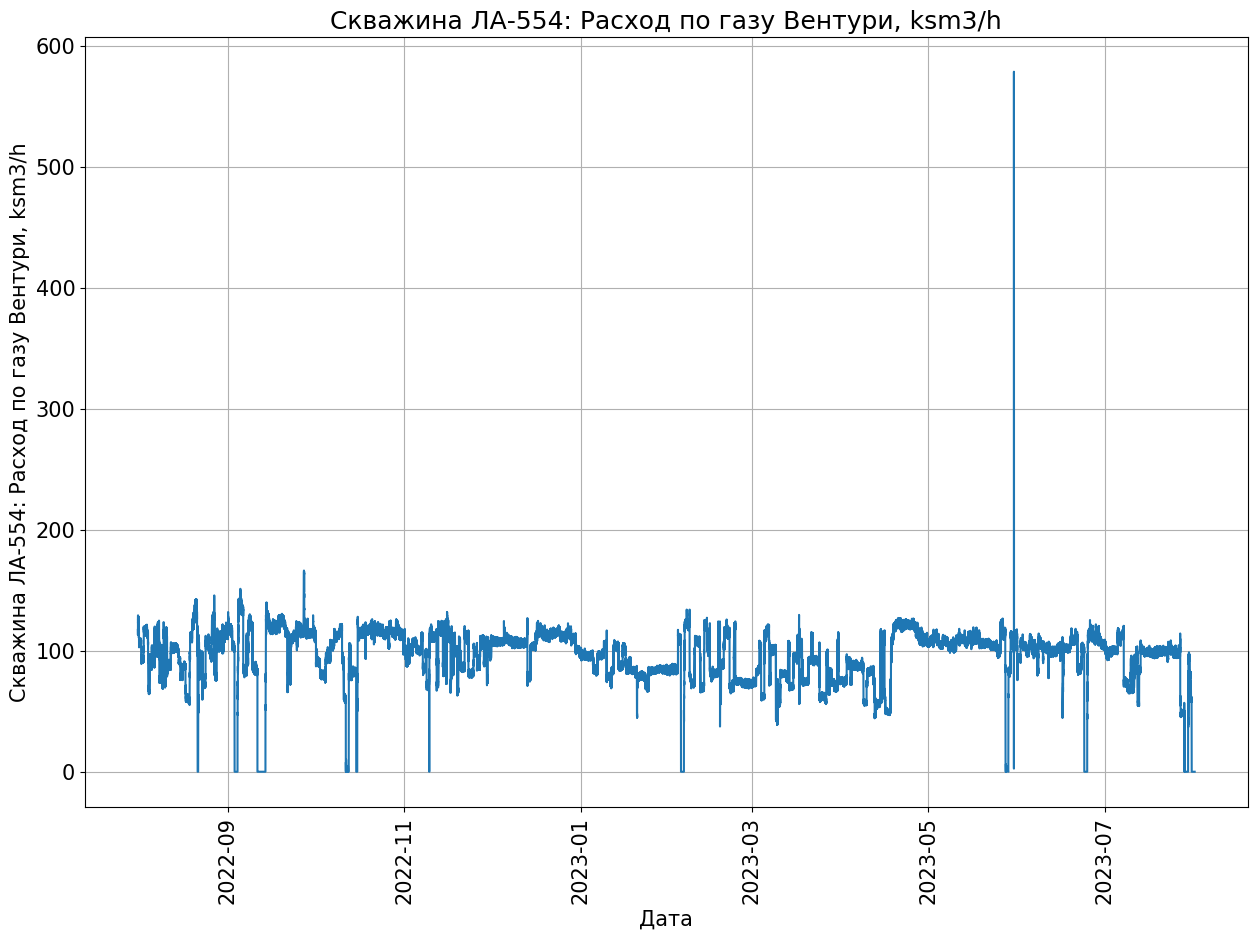

In [55]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-554: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-554: Расход по газу Вентури, ksm3/h')
plt.grid()

In [56]:
'''
df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-521

## 77. Скважина ЛА-521: Расход по газу Вентури, ksm3/h

In [57]:
#count_words(df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'], pattern)

In [58]:
'''
df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                           pattern = pattern) == False \
                                                         else None)

df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                           pattern = pattern) == False                                                          else None)\n\ndf['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

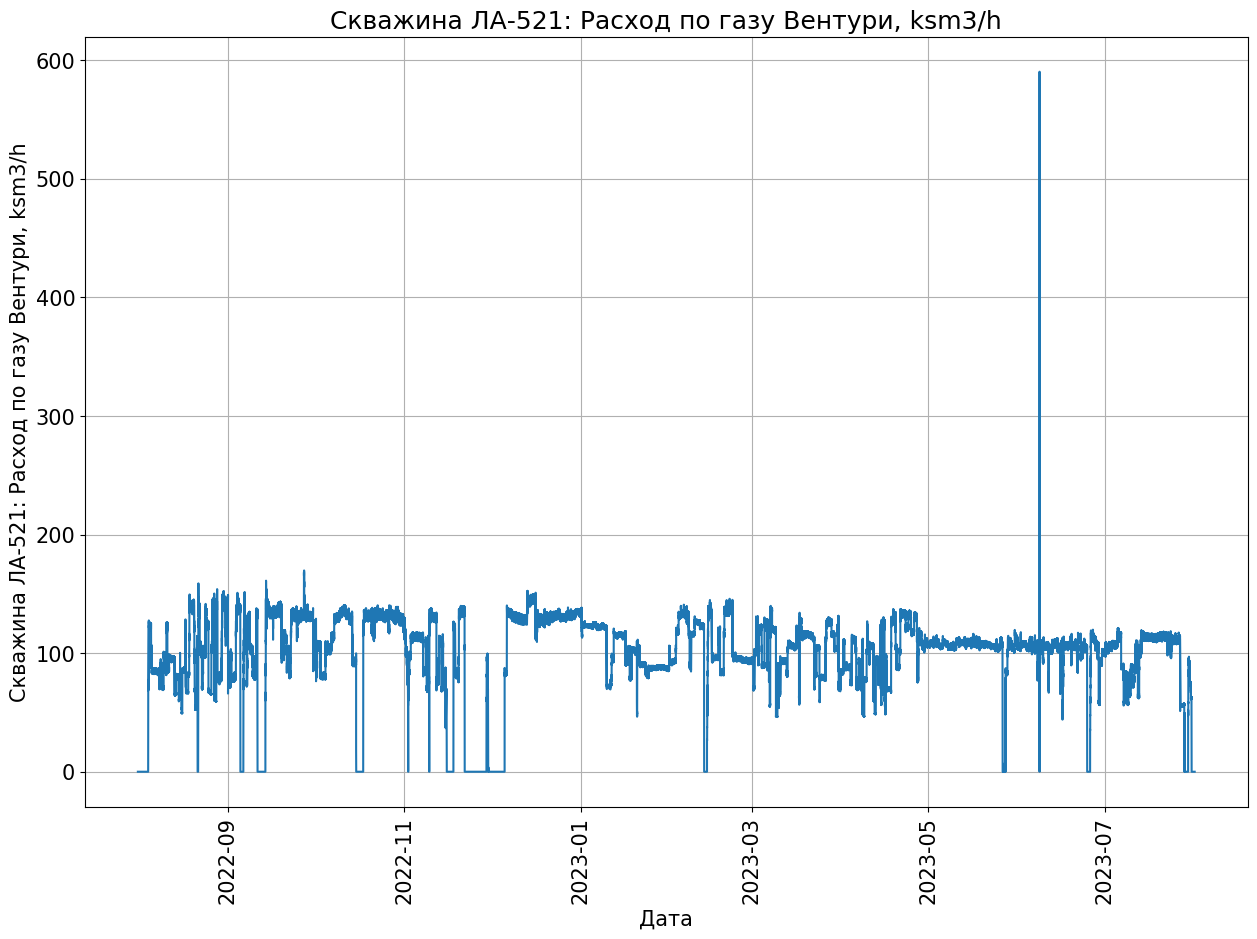

In [59]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-521: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-521: Расход по газу Вентури, ksm3/h')
plt.grid()

In [60]:
'''
df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-522

## 90. Скважина ЛА-522: Расход по газу Вентури, ksm3/h

In [61]:
#count_words(df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'], pattern)

In [62]:
'''
df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

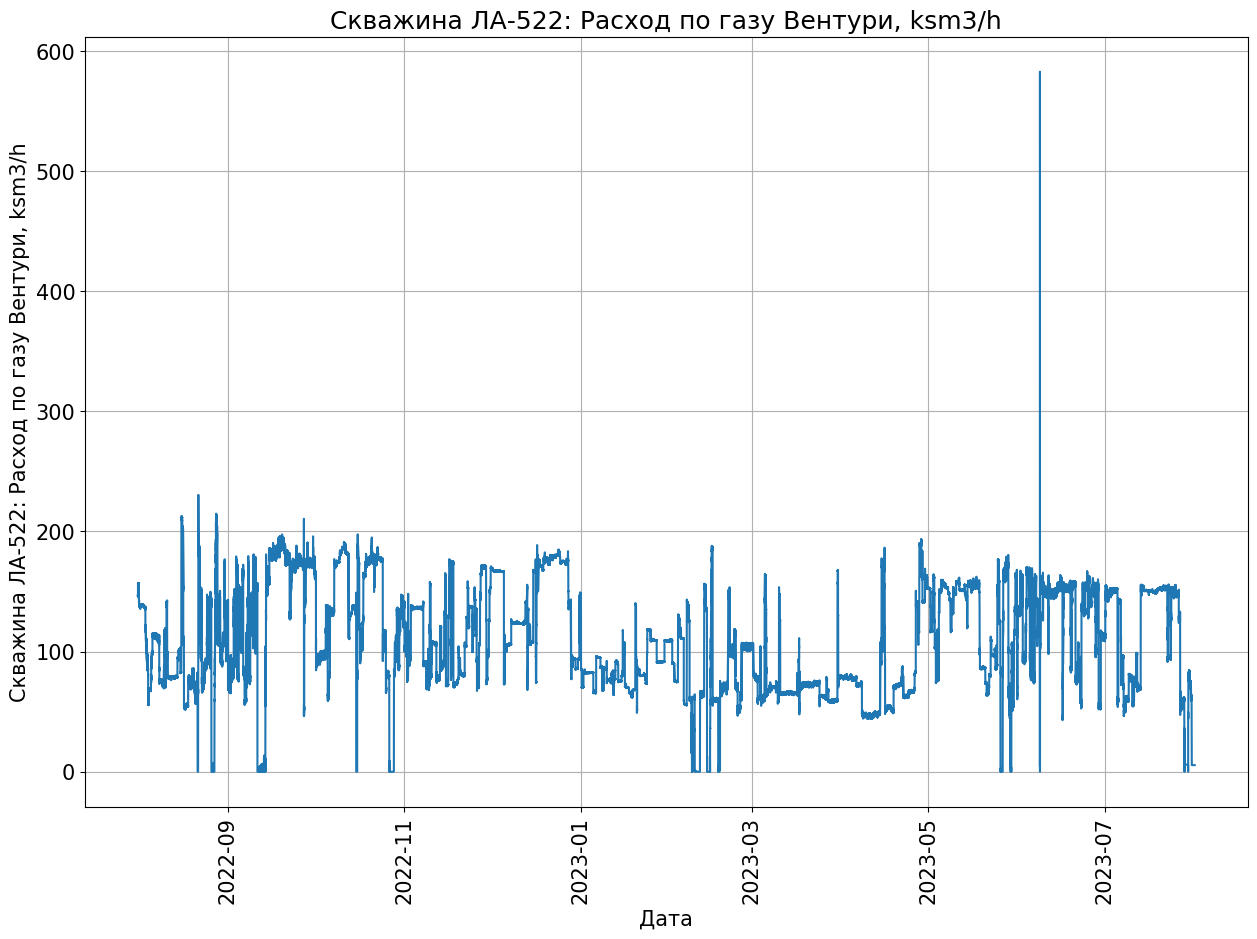

In [63]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-522: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-522: Расход по газу Вентури, ksm3/h')
plt.grid()

In [64]:
'''
df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-528

## 103. Скважина ЛА-528: Расход по газу Вентури, ksm3/h

In [65]:
#count_words(df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'], pattern)

In [66]:
'''
df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

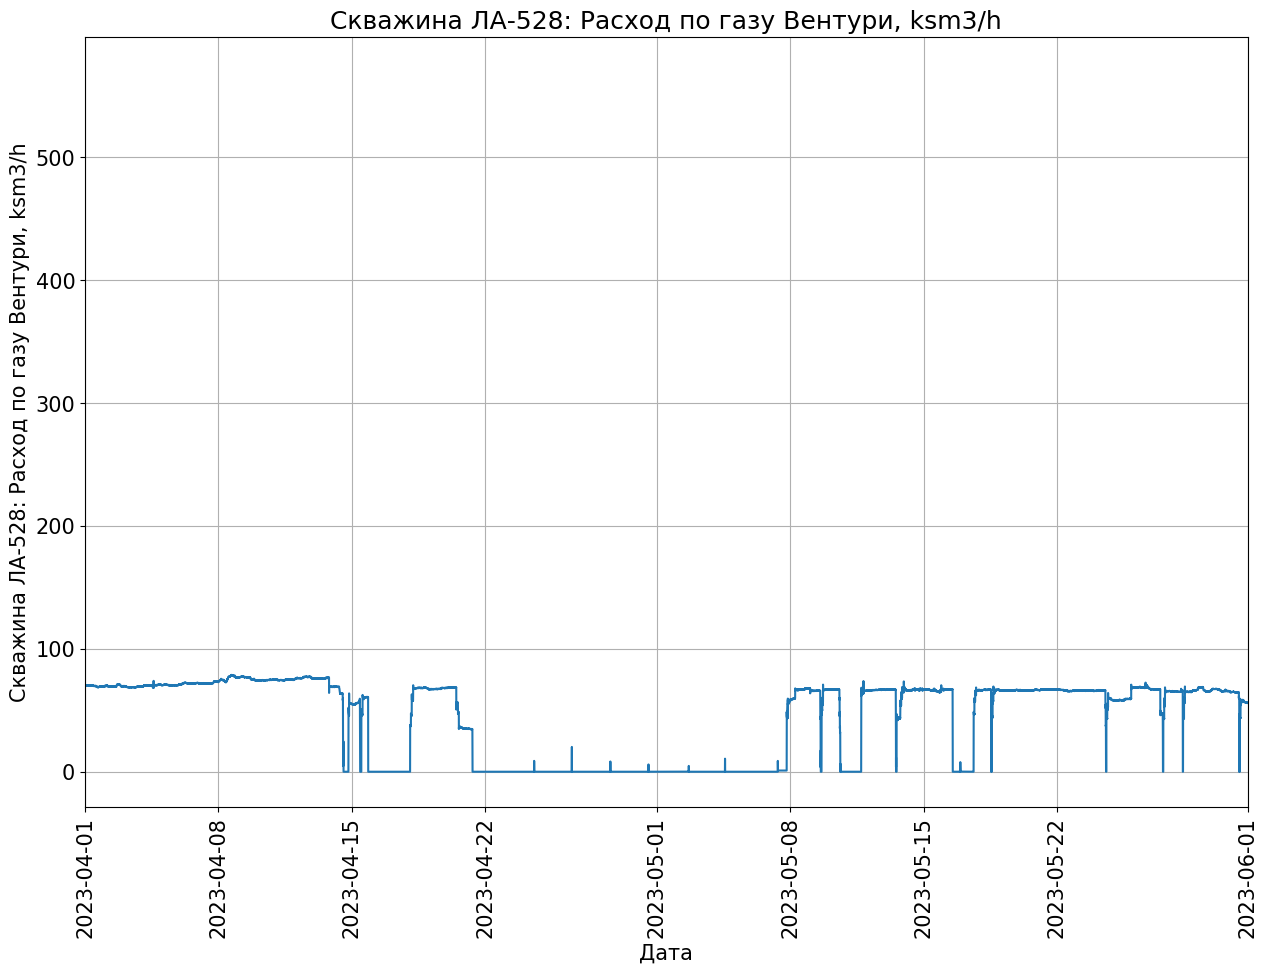

In [67]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'])
plt.xlim([datetime.strptime('2023-04-01 00:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2023-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-528: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-528: Расход по газу Вентури, ksm3/h')
plt.grid()

In [68]:
'''
df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-503

## 116. Скважина ЛА-503: Расход по конденсату Вентури, sm3/h

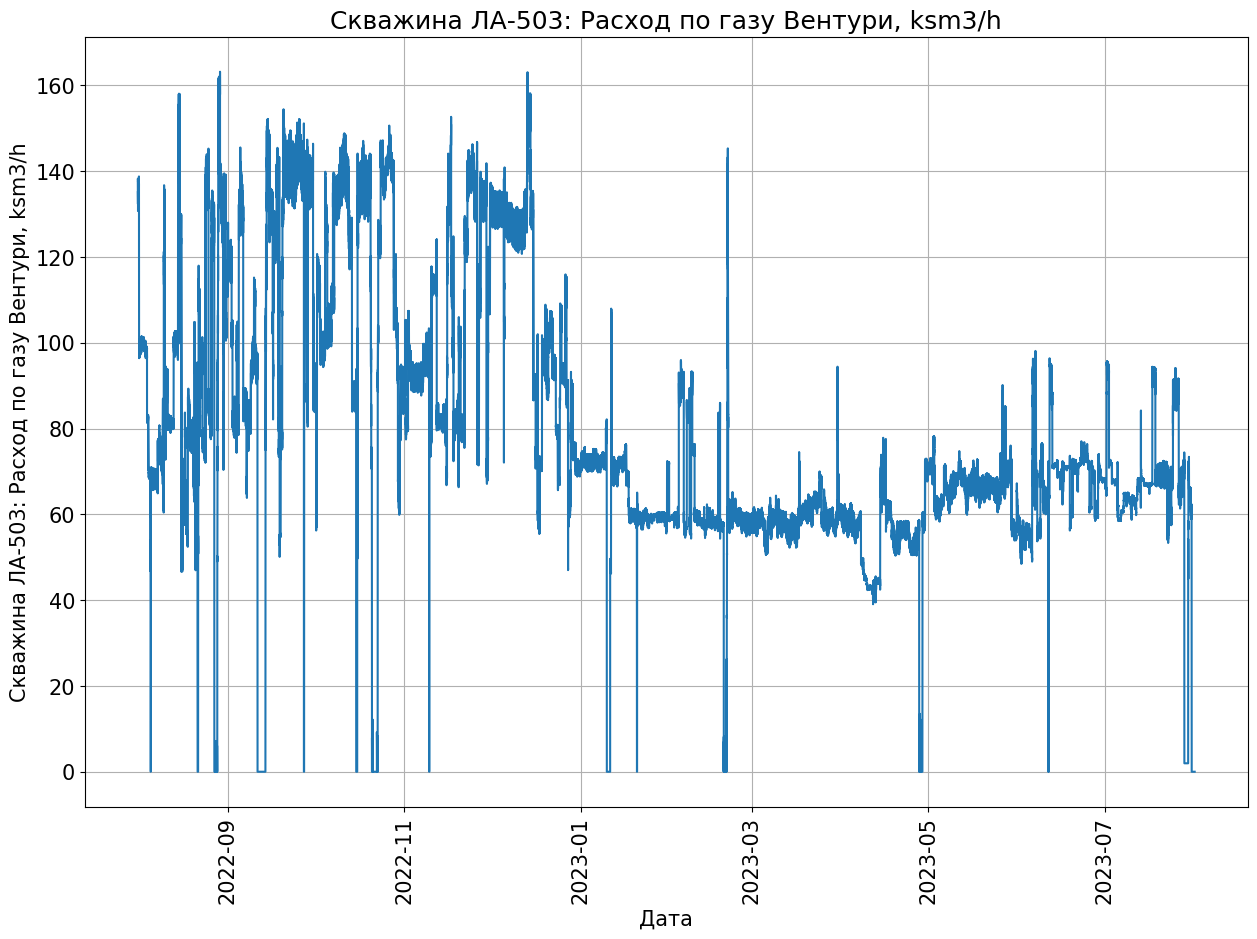

In [69]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-503: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-503: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-503: Расход по газу Вентури, ksm3/h')
plt.grid()

# Скважина ЛА-517

## 129. Скважина ЛА-517: Расход по газу Вентури, ksm3/h

In [70]:
#count_words(df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'], pattern)

In [71]:
'''
df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

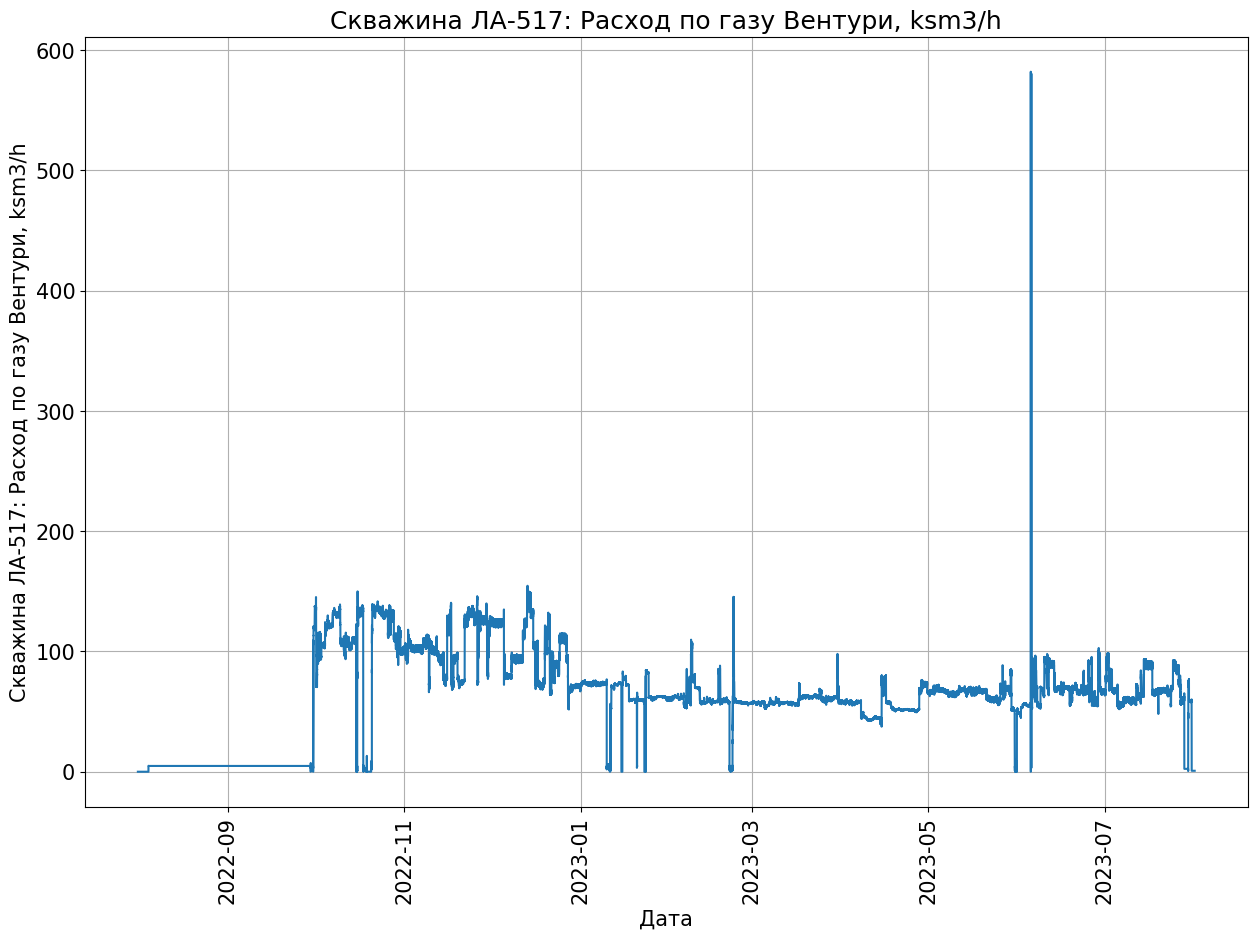

In [72]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-517: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-517: Расход по газу Вентури, ksm3/h')
plt.grid()

In [73]:
'''
df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

# Скважина ЛА-506

## 142. Скважина ЛА-506: Расход по газу Вентури, ksm3/h

In [74]:
#count_words(df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'], pattern)

In [75]:
'''
df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, 
                                                                                              pattern = pattern) == False \
                                                            else None)

df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].apply(lambda x: float(x) if word_search(x = x, \n                                                                                              pattern = pattern) == False                                                             else None)\n\ndf['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

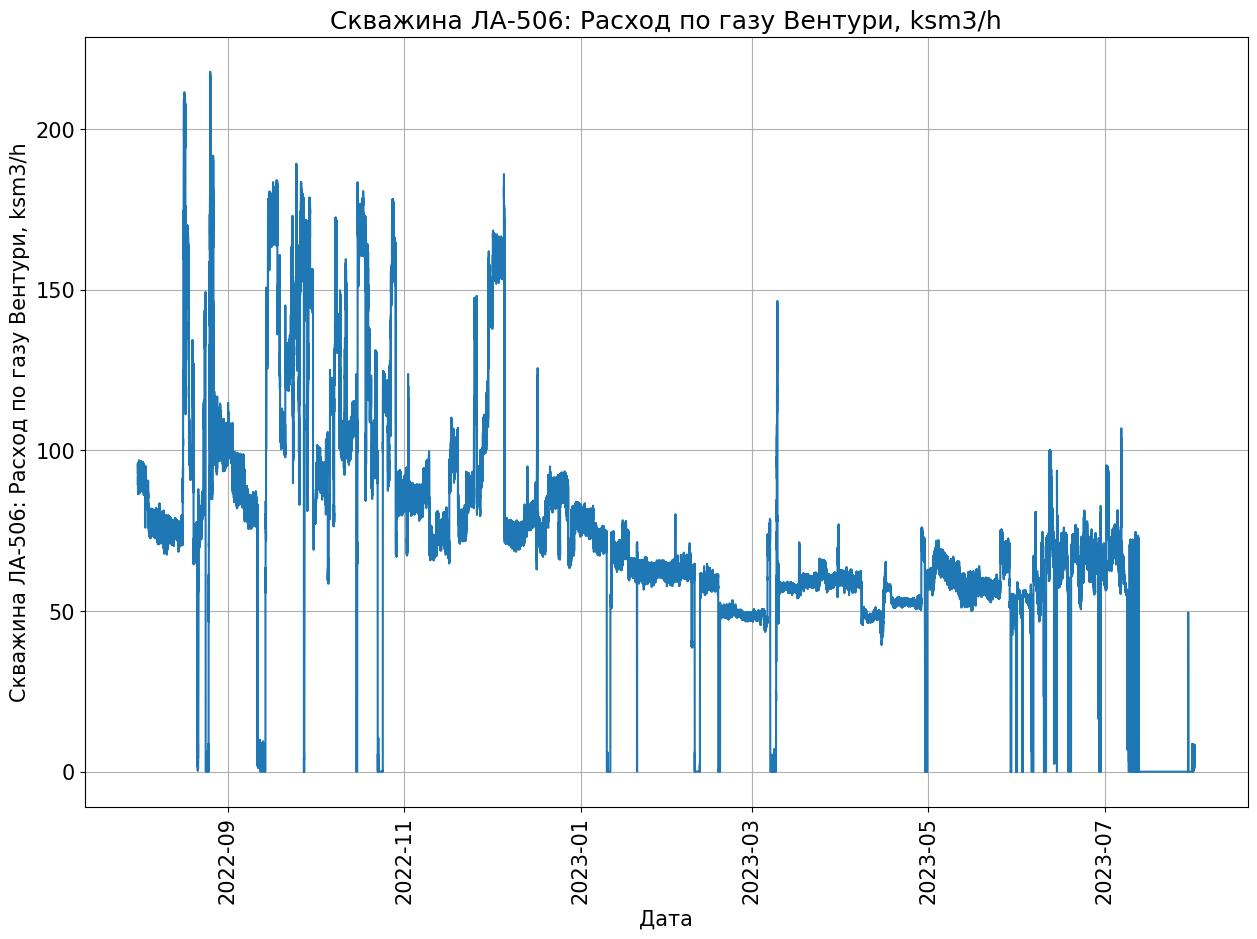

In [76]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'])
#plt.xlim([datetime.strptime('2023-02-19 18:00:00', '%Y-%m-%d %H:%M:%S'), \
#          datetime.strptime('2023-02-21 23:00:00', '%Y-%m-%d %H:%M:%S')])
plt.xticks(rotation = 90)
#plt.legend(['Процент открытия штуцера, %'])
plt.title('Скважина ЛА-506: Расход по газу Вентури, ksm3/h')
plt.xlabel('Дата')
plt.ylabel('Скважина ЛА-506: Расход по газу Вентури, ksm3/h')
plt.grid()

In [77]:
'''
df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'] = \
df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')

df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].isna().sum()
'''

"\ndf['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'] = df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].interpolate(method = 'linear')\n\ndf['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'].isna().sum()\n"

### Расчёт суммарного расхода по газу Вентури на всех скважинах ТЛ1

In [78]:
df['ТЛ1: Суммарный расход по газу Вентури, kSm3/h'] = \
df['Скважина ЛА-529: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-508: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-504: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-524: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-554: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-503: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'] + \
df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h']

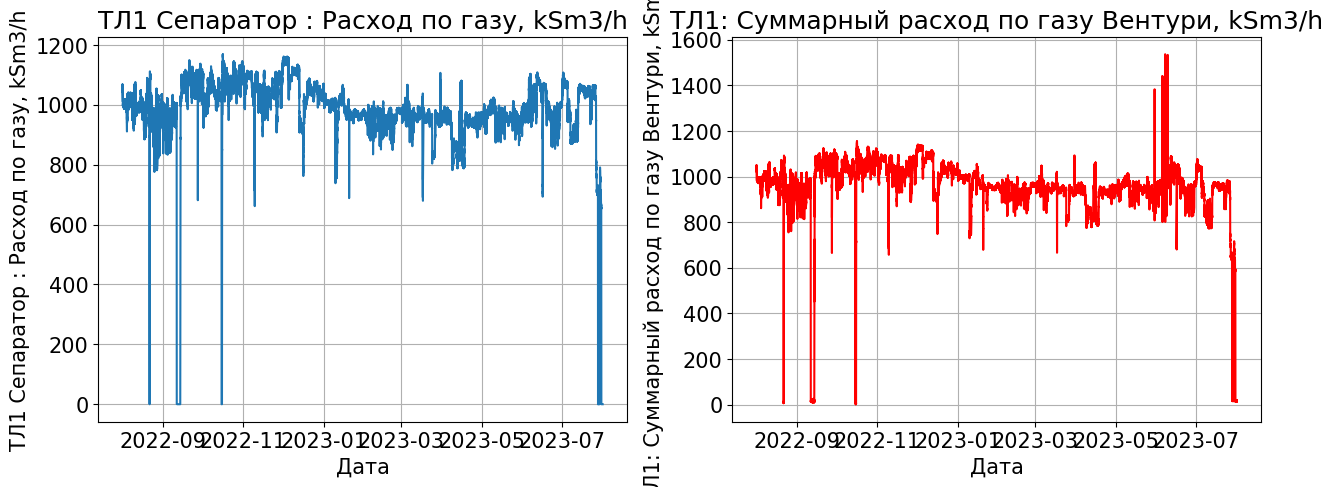

In [79]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(df['time'], df['ТЛ1 Сепаратор : Расход по газу, kSm3/h'])
ax[0].set_title('ТЛ1 Сепаратор : Расход по газу, kSm3/h')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('ТЛ1 Сепаратор : Расход по газу, kSm3/h')
ax[0].grid()

ax[1].plot(df['time'], df['ТЛ1: Суммарный расход по газу Вентури, kSm3/h'], c = 'r')
ax[1].set_title('ТЛ1: Суммарный расход по газу Вентури, kSm3/h')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('ТЛ1: Суммарный расход по газу Вентури, kSm3/h')
ax[1].grid()

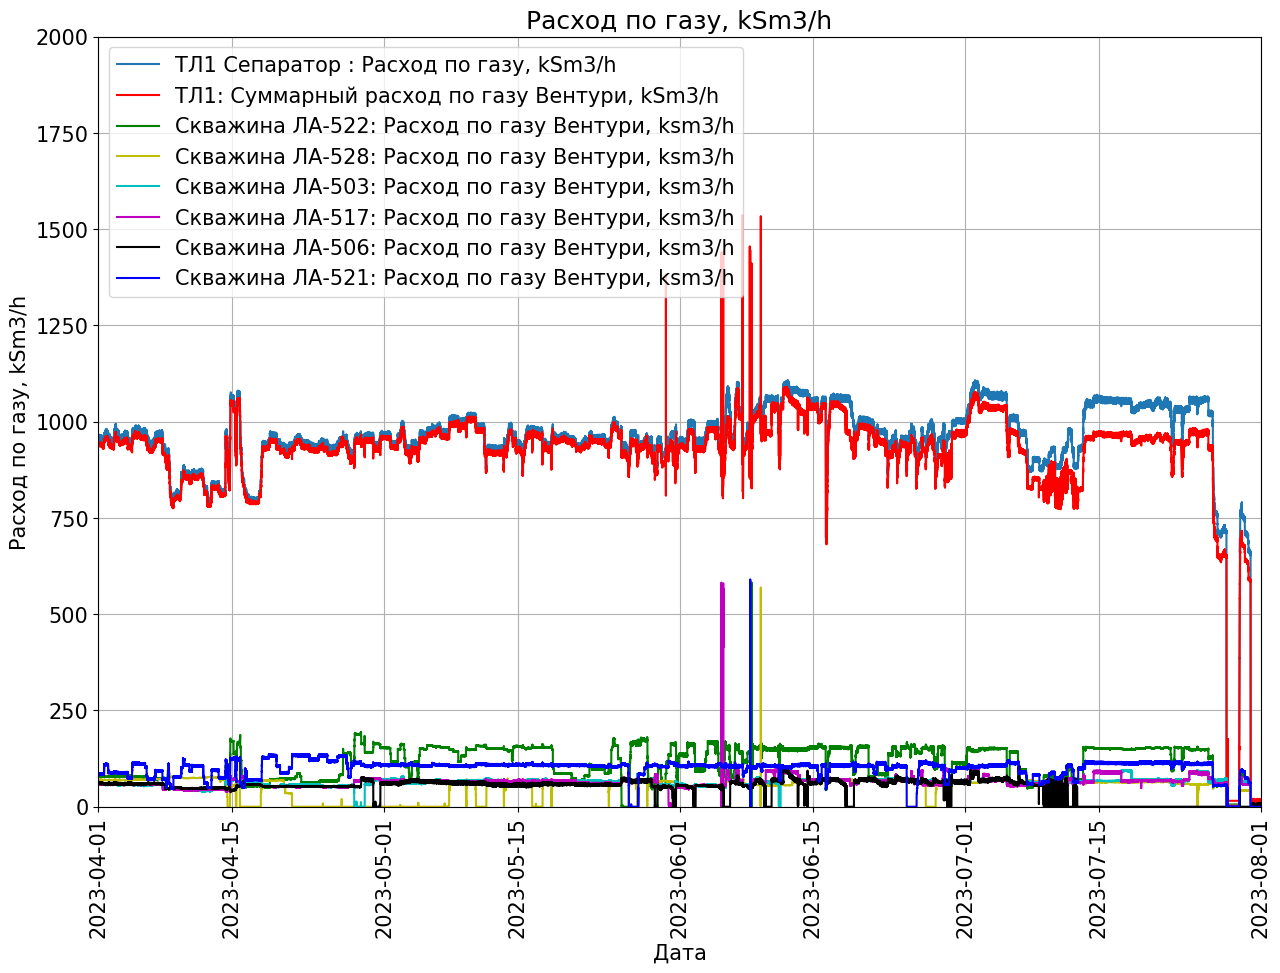

In [80]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['ТЛ1 Сепаратор : Расход по газу, kSm3/h'])
plt.plot(df['time'], df['ТЛ1: Суммарный расход по газу Вентури, kSm3/h'], c = 'r')
plt.plot(df['time'], df['Скважина ЛА-522: Расход по газу Вентури, ksm3/h'], c = 'g')
plt.plot(df['time'], df['Скважина ЛА-528: Расход по газу Вентури, ksm3/h'], c = 'y')
plt.plot(df['time'], df['Скважина ЛА-503: Расход по газу Вентури, ksm3/h'], c = 'c')
plt.plot(df['time'], df['Скважина ЛА-517: Расход по газу Вентури, ksm3/h'], c = 'm')
plt.plot(df['time'], df['Скважина ЛА-506: Расход по газу Вентури, ksm3/h'], c = 'k')
plt.plot(df['time'], df['Скважина ЛА-521: Расход по газу Вентури, ksm3/h'], c = 'b')
plt.xlim([datetime.strptime('2023-04-01 00:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2023-08-01 00:00:00', '%Y-%m-%d %H:%M:%S')])
plt.ylim(0, 2000)
plt.xticks(rotation = 90)
plt.legend(['ТЛ1 Сепаратор : Расход по газу, kSm3/h', 'ТЛ1: Суммарный расход по газу Вентури, kSm3/h', 
            'Скважина ЛА-522: Расход по газу Вентури, ksm3/h', 'Скважина ЛА-528: Расход по газу Вентури, ksm3/h', 
            'Скважина ЛА-503: Расход по газу Вентури, ksm3/h', 'Скважина ЛА-517: Расход по газу Вентури, ksm3/h', 
            'Скважина ЛА-506: Расход по газу Вентури, ksm3/h', 'Скважина ЛА-521: Расход по газу Вентури, ksm3/h'])
plt.title('Расход по газу, kSm3/h')
plt.xlabel('Дата')
plt.ylabel('Расход по газу, kSm3/h')
plt.grid()

In [81]:
df['ТЛ1 Сепаратор : Расход по газу, kSm3/h'].mean()*8760

8575300.478461917

In [82]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051201 entries, 0 to 1051200
Data columns (total 155 columns):
 #    Column                                                               Dtype         
---   ------                                                               -----         
 0    time                                                                 datetime64[ns]
 1    Платформа: Температура окружающей среды, degC                        float64       
 2    ТЛ1 Сепаратор : Расход по газу, kSm3/h                               float64       
 3    ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                          float64       
 4    ТЛ1 Сепаратор : Расход по воде  , m3/h                               float64       
 5    ТЛ1 Сепаратор : Температура на выходе газа, degC                     float64       
 6    ТЛ1 Сепаратор : Температура на выходе конденсата, degC               float64       
 7    ТЛ1 Сепаратор : Давление на выходе газа, barg                        f

В результате анализа графика было обнаружено:

- аномальное поведение скважины ЛА-554 - *2023-05-30 с 13:35:00 до 13:50:00*
- аномальное поведение скважины ЛА-517 - *2023-06-05 с 09:10:00 до 09:30:00*
- аномальное поведение скважины ЛА-529 - *2023-06-05 с 12:45:00 до 13:10:00*
- аномальное поведение скважины ЛА-517 - *2023-06-05 с 13:50:00 до 14:10:00*
- аномальное поведение скважины ЛА-508 - *2023-06-07 с 14:00:00 до 14:10:00* и *с 15:25:00 до 16:00:00*
- аномальное поведение скважины ЛА-504 - *2023-06-07 с 14:10:00 до 14:50:00*
- аномальное поведение скважины ЛА-524 - *2023-06-08 с 08:45:00 до 09:30:00*
- аномальное поведение скважины ЛА-522 - *2023-06-08 с 13:10:00 до 13:50:00*
- аномальное поведение скважины ЛА-521 - *2023-06-08 с 09:45:00 до 10:30:00*
- аномальное поведение скважины ЛА-528 - *2023-06-09 с 12:35:00 до 12:55:00*
- аномальное поведение скважины ЛА-506 - *с 2023-06-09 21:00:00 до 2023-06-10 16:00:00*
- аномальное поведение скважины ЛА-503 - *2023-06-11 с 10:05:00 до 10:15:00*, *с 10:35:00 до 10:55:00* и *с 12:45:00 до 13:45:00*
- аномальное поведение скважины ЛА-506 - *с 2023-06-12 00:00:00 до 2023-06-14 12:00:00*
- аномальное поведение скважины ЛА-506 - *с 2023-06-17 15:00:00 до 2023-06-19 08:00:00*

In [83]:
df1 = df[['time', 'Скважина ЛА-506: Процент открытия штуцера, %', 'Скважина ЛА-506: Расход по газу Вентури, ksm3/h', 
          'Скважина ЛА-506: Расход по конденсату Вентури, sm3/h', 'Скважина ЛА-506: Расход по воде Вентури, sm3/h', 
          'Скважина ЛА-506: Температура на трубке Вентури, degC', 'Скважина ЛА-506: Перепад давления на трубке Вентури газ, mbar', 
          'Скважина ЛА-506: Перепад давления на трубке Вентури конденсат, mbar', 'Скважина ЛА-506: Перепад давления на трубке Вентури вода, mbar', 
          'Скважина ЛА-506: Давление на трубке Вентури, bara', 'Скважина ЛА-506: Температура на выкидной линии, degC', 
          'Скважина ЛА-506: Давление над буферной задвижкой ФА, barg', 'Скважина ЛА-506: Температура забойная, degC']]
df1

time  Скважина ЛА-506: Процент открытия штуцера, %  \
0       2022-08-01 00:00:00                                         28.97   
1       2022-08-01 00:00:30                                         28.97   
2       2022-08-01 00:01:00                                         28.97   
3       2022-08-01 00:01:30                                         28.97   
4       2022-08-01 00:02:00                                         28.97   
...                     ...                                           ...   
1051196 2023-07-31 23:58:00                                          0.00   
1051197 2023-07-31 23:58:30                                          0.00   
1051198 2023-07-31 23:59:00                                          0.00   
1051199 2023-07-31 23:59:30                                          0.00   
1051200 2023-08-01 00:00:00                                          0.00   

         Скважина ЛА-506: Расход по газу Вентури, ksm3/h  \
0                                              91.515210   
1                                              91.289870   
2                                              93.058850   
3                                              92.387960   
4                                              91.902700   
...                                                  ...   
1051196                                         4.068194   
1051197                                         4.749808   
1051198                                         7.492866   
1051199                                         6.225318   
1051200                                         4.961995   

         Скважина ЛА-506: Расход по конденсату Вентури, sm3/h  \
0                                                10.645260      
1                                                10.622170      
2                                                10.827250      
3                                                10.749840      
4                                                10.694540      
...                                                    ...      
1051196                                           0.750634      
1051197                                           0.876433      
1051198                                           1.382702      
1051199                                           1.148825      
1051200                                           0.915591      

         Скважина ЛА-506: Расход по воде Вентури, sm3/h  \
0                                              7.266355   
1                                              7.535366   
2                                              5.589315   
3                                              5.807997   
4                                              5.531795   
...                                                 ...   
1051196                                        0.000000   
1051197                                        0.000000   
1051198                                        0.000000   
1051199                                        0.000000   
1051200                                        0.000000   

         Скважина ЛА-506: Температура на трубке Вентури, degC  \
0                                                 61.69806      
1                                                 61.69832      
2                                                 61.69859      
3                                                 61.69886      
4                                                 61.69913      
...                                                    ...      
1051196                                           25.08305      
1051197                                           25.07876      
1051198                                           25.07446      
1051199                                           25.07017      
1051200                                           25.06588      

         Скважина ЛА-506: Перепад давления на трубке Вентури газ, mbar  \
0                               

In [84]:
X = MinMaxScaler().fit_transform(df1.iloc[:, 1:])

In [85]:
X.shape

(1051201, 12)

In [86]:
len(X[:, 0])

1051201

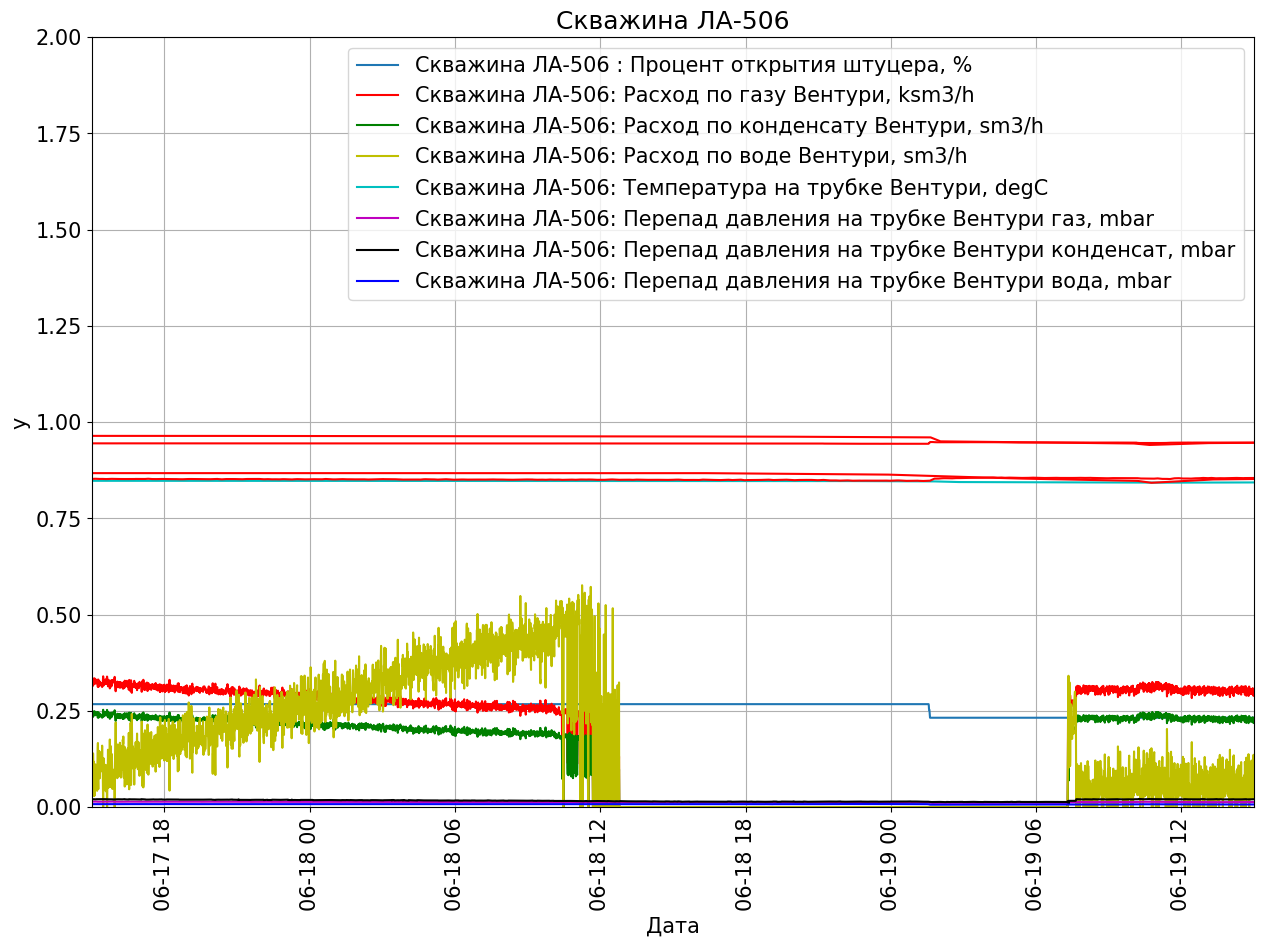

In [87]:
#plt.figure(figsize = (10, 8))
plt.plot(df1['time'], X[:, 0])
plt.plot(df1['time'], X[:, 1], c = 'r')
plt.plot(df1['time'], X[:, 2], c = 'g')
plt.plot(df1['time'], X[:, 3], c = 'y')
plt.plot(df1['time'], X[:, 4], c = 'c')
plt.plot(df1['time'], X[:, 5], c = 'm')
plt.plot(df1['time'], X[:, 6], c = 'k')
plt.plot(df1['time'], X[:, 7], c = 'b')
plt.plot(df1['time'], X[:, 8], c = 'r')
plt.plot(df1['time'], X[:, 9], c = 'r')
plt.plot(df1['time'], X[:, 10], c = 'r')
plt.plot(df1['time'], X[:, 11], c = 'r')
plt.xlim([datetime.strptime('2023-06-17 15:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2023-06-19 15:00:00', '%Y-%m-%d %H:%M:%S')])
plt.ylim(0, 2)
plt.xticks(rotation = 90)
plt.legend(['Скважина ЛА-506 : Процент открытия штуцера, %', 'Скважина ЛА-506: Расход по газу Вентури, ksm3/h', 
            'Скважина ЛА-506: Расход по конденсату Вентури, sm3/h', 'Скважина ЛА-506: Расход по воде Вентури, sm3/h', 
            'Скважина ЛА-506: Температура на трубке Вентури, degC', 'Скважина ЛА-506: Перепад давления на трубке Вентури газ, mbar', 
            'Скважина ЛА-506: Перепад давления на трубке Вентури конденсат, mbar', 'Скважина ЛА-506: Перепад давления на трубке Вентури вода, mbar'])
plt.title('Скважина ЛА-506')
plt.xlabel('Дата')
plt.ylabel('y')
plt.grid()

### Расчёт разницы расхода по газу на сепараторе и суммарного расхода по газу Вентури

In [88]:
df['Дельта расхода по газу, kSm3/h'] = abs(df['ТЛ1 Сепаратор : Расход по газу, kSm3/h'] - \
df['ТЛ1: Суммарный расход по газу Вентури, kSm3/h'])

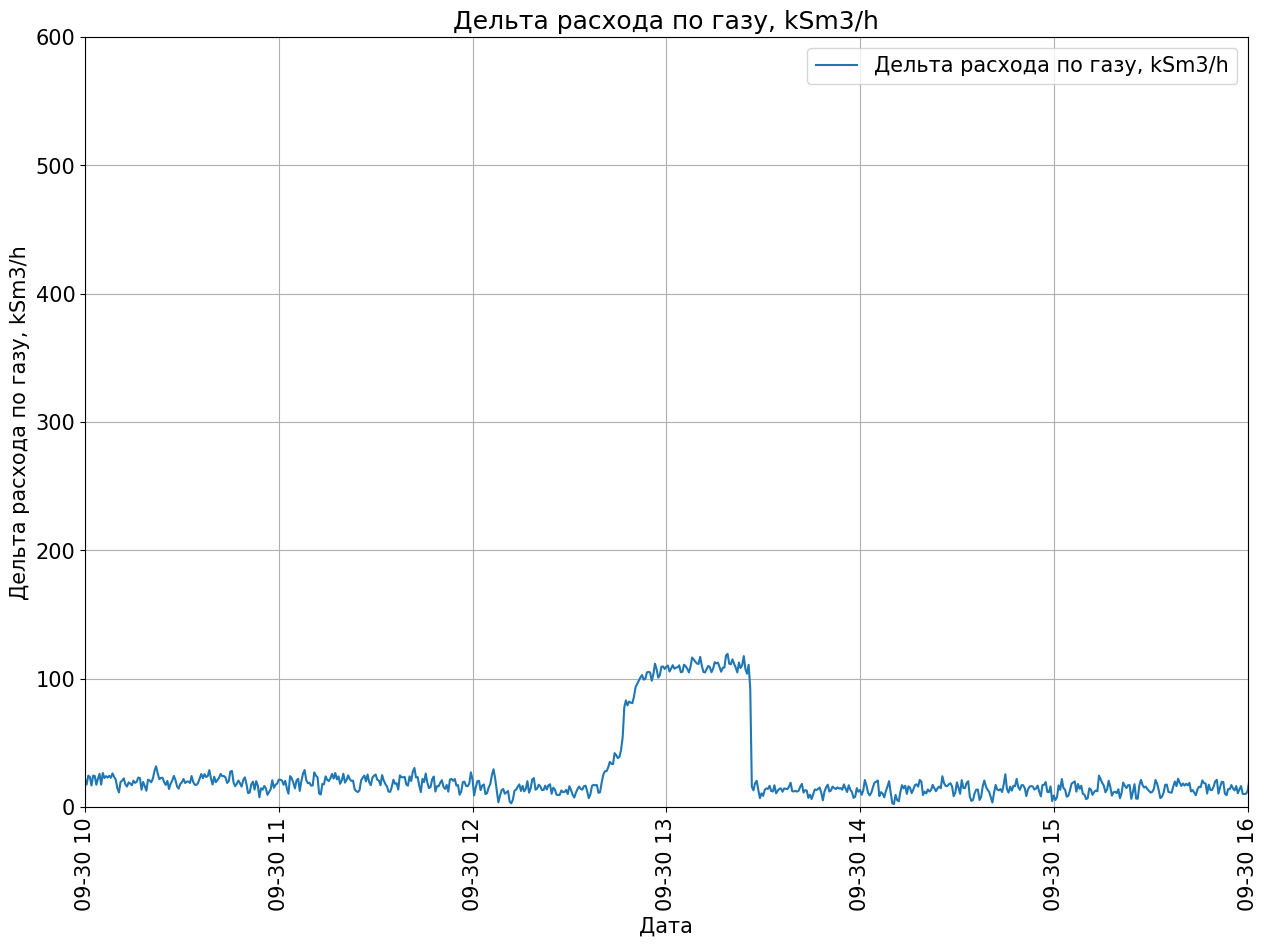

In [89]:
#plt.figure(figsize = (10, 8))
plt.plot(df['time'], df['Дельта расхода по газу, kSm3/h'])
plt.xlim([datetime.strptime('2022-09-30 10:00:00', '%Y-%m-%d %H:%M:%S'), \
          datetime.strptime('2022-09-30 16:00:00', '%Y-%m-%d %H:%M:%S')])
plt.ylim(0, 600)
plt.xticks(rotation = 90)
plt.legend(['Дельта расхода по газу, kSm3/h'])
plt.title('Дельта расхода по газу, kSm3/h')
plt.xlabel('Дата')
plt.ylabel('Дельта расхода по газу, kSm3/h')
plt.grid()

In [90]:
print('Расхождение суммарного расхода по газу Вентури с расходом по газу на сепараторе составляет:', \
      round(df['Дельта расхода по газу, kSm3/h'].mean()/df['ТЛ1 Сепаратор : Расход по газу, kSm3/h'].mean()*100, 2), '%')

Расхождение суммарного расхода по газу Вентури с расходом по газу на сепараторе составляет: 2.17 %


In [91]:
round(df[(df['time'] > datetime.strptime('2023-07-13 00:00:00', '%Y-%m-%d %H:%M:%S')) &\
         (df['time'] < datetime.strptime('2023-07-27 00:00:00', '%Y-%m-%d %H:%M:%S'))]['Дельта расхода по газу, kSm3/h'].mean()/
      df[(df['time'] > datetime.strptime('2023-07-13 00:00:00', '%Y-%m-%d %H:%M:%S')) &\
         (df['time'] < datetime.strptime('2023-07-27 00:00:00', '%Y-%m-%d %H:%M:%S'))]['ТЛ1 Сепаратор : Расход по газу, kSm3/h'].mean()*100, 2)

8.45

In [92]:
df.head()

time  Платформа: Температура окружающей среды, degC  \
0 2022-08-01 00:00:00                                       13.56105   
1 2022-08-01 00:00:30                                       13.57446   
2 2022-08-01 00:01:00                                       13.58788   
3 2022-08-01 00:01:30                                       13.60461   
4 2022-08-01 00:02:00                                       13.62154   

   ТЛ1 Сепаратор : Расход по газу, kSm3/h  \
0                                1050.821   
1                                1050.176   
2                                1050.351   
3                                1050.908   
4                                1046.780   

   ТЛ1 Сепаратор : Расход по конденсату, Sm3/h  \
0                                     37.12975   
1                                     37.56005   
2                                     37.03209   
3                                     37.16535   
4                                     36.90152   

   ТЛ1 Сепаратор : Расход по воде  , m3/h  \
0                                0.188499   
1                                0.188499   
2                                0.188499   
3                                2.345471   
4                                3.685060   

   ТЛ1 Сепаратор : Температура на выходе газа, degC  \
0                                          59.42110   
1                                          59.42216   
2                                          59.42322   
3                                          59.42428   
4                                          59.42533   

   ТЛ1 Сепаратор : Температура на выходе конденсата, degC  \
0                                           59.61190        
1                                           59.61227        
2                                           59.61264        
3                                           59.61302        
4                                           59.61340        

   ТЛ1 Сепаратор : Давление на выходе газа, barg  \
0                                       94.68169   
1                                       94.68456   
2                                       94.68744   
3                                       94.69032   
4                                       94.69319   

   ТЛ1 Сепаратор : Давление на выходе конденсата, barg  \
0                                           95.24151     
1                                           95.24427     
2                                           95.24703     
3                                           95.24979     
4                                           95.25256     

   ТЛ1 Манифольд : Давление, barg  ТЛ1 Манифольд : Температура, degC  \
0                        95.62689                           59.85884   
1                        95.63401                           59.85986   
2                        95.63639                           59.86087   
3                        95.63801                           59.86189   
4                        95.63963                           59.86290   

   Скважина ЛА-529 : Процент открытия штуцера, %  \
0                                       55.66615   
1                                       55.66611   
2                                       55.66608   
3                                       55.66605   
4                                       55.66602   

   Скважина ЛА-529: Расход по газу Вентури, ksm3/h  \
0                                         119.0700   
1                                         119.0718   
2                                         119.0735   
3                                         119.0753   
4                                         119.0770   

   Скважина ЛА-529: Расход по конденсату Вентури, sm3/h  \
0                                           14.75711      
1                                           14.75645      
2                                           14.75578      
3                                           14.75511      
4              

Построим корреляционную матрицу признаков, из которой исключим колонку времени.

In [93]:
correlation = df.iloc[:, 1:].corr()

In [94]:
correlation

Платформа: Температура окружающей среды, degC  \
Платформа: Температура окружающей среды, degC                                            1.000000   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                  -0.109982   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                             -0.130379   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                                  -0.077527   
ТЛ1 Сепаратор : Температура на выходе газа, degC                                        -0.039341   
...                                                                                           ...   
Скважина ЛА-506: Давление над буферной задвижко...                                      -0.016463   
Скважина ЛА-506: Температура забойная, degC                                             -0.096073   
Скважина ЛА-506: Давление забойное, barg                                                -0.092283   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                           -0.158713   
Дельта расхода по газу, kSm3/h                                                           0.364103   

                                                    ТЛ1 Сепаратор : Расход по газу, kSm3/h  \
Платформа: Температура окружающей среды, degC                                    -0.109982   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                            1.000000   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                       0.633497   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                            0.052446   
ТЛ1 Сепаратор : Температура на выходе газа, degC                                  0.888533   
...                                                                                    ...   
Скважина ЛА-506: Давление над буферной задвижко...                               -0.119470   
Скважина ЛА-506: Температура забойная, degC                                       0.429200   
Скважина ЛА-506: Давление забойное, barg                                         -0.313878   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                     0.990376   
Дельта расхода по газу, kSm3/h                                                    0.076235   

                                                    ТЛ1 Сепаратор : Расход по конденсату, Sm3/h  \
Платформа: Температура окружающей среды, degC                                         -0.130379   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                 0.633497   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                            1.000000   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                                -0.082346   
ТЛ1 Сепаратор : Температура на выходе газа, degC                                       0.535090   
...                                                                                         ...   
Скважина ЛА-506: Давление над буферной задвижко...                                    -0.017930   
Скважина ЛА-506: Температура забойная, degC                                            0.357423   
Скважина ЛА-506: Давление забойное, barg                                               0.054677   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                          0.645783   
Дельта расхода по газу, kSm3/h                                                        -0.110013   

                                                    ТЛ1 Сепаратор : Расход по воде  , m3/h  \
Платформа: Температура окружающей среды, degC                                    -0.077527   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                            0.052446   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                      -0.082346   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                            1.000000   
ТЛ1 Сепаратор : Температура на выходе газа, degC   

In [95]:
correlation[(correlation < -0.5) | (correlation > 0.5)]

Платформа: Температура окружающей среды, degC  \
Платформа: Температура окружающей среды, degC                                                 1.0   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                        NaN   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                                   NaN   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                                        NaN   
ТЛ1 Сепаратор : Температура на выходе газа, degC                                              NaN   
...                                                                                           ...   
Скважина ЛА-506: Давление над буферной задвижко...                                            NaN   
Скважина ЛА-506: Температура забойная, degC                                                   NaN   
Скважина ЛА-506: Давление забойное, barg                                                      NaN   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                                 NaN   
Дельта расхода по газу, kSm3/h                                                                NaN   

                                                    ТЛ1 Сепаратор : Расход по газу, kSm3/h  \
Платформа: Температура окружающей среды, degC                                          NaN   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                            1.000000   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                       0.633497   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                                 NaN   
ТЛ1 Сепаратор : Температура на выходе газа, degC                                  0.888533   
...                                                                                    ...   
Скважина ЛА-506: Давление над буферной задвижко...                                     NaN   
Скважина ЛА-506: Температура забойная, degC                                            NaN   
Скважина ЛА-506: Давление забойное, barg                                               NaN   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                     0.990376   
Дельта расхода по газу, kSm3/h                                                         NaN   

                                                    ТЛ1 Сепаратор : Расход по конденсату, Sm3/h  \
Платформа: Температура окружающей среды, degC                                               NaN   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                 0.633497   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                            1.000000   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                                      NaN   
ТЛ1 Сепаратор : Температура на выходе газа, degC                                       0.535090   
...                                                                                         ...   
Скважина ЛА-506: Давление над буферной задвижко...                                          NaN   
Скважина ЛА-506: Температура забойная, degC                                                 NaN   
Скважина ЛА-506: Давление забойное, barg                                                    NaN   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                          0.645783   
Дельта расхода по газу, kSm3/h                                                              NaN   

                                                    ТЛ1 Сепаратор : Расход по воде  , m3/h  \
Платформа: Температура окружающей среды, degC                                          NaN   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                 NaN   
ТЛ1 Сепаратор : Расход по конденсату, Sm3/h                                            NaN   
ТЛ1 Сепаратор : Расход по воде  , m3/h                                                 1.0   
ТЛ1 Сепаратор : Температура на выходе газа, degC   

Посмотрим на корреляцию только одних скважин между собой.

In [96]:
well_corr = correlation.iloc[[11, 24, 37, 50, 63, 76, 89, 102, 115, 128, 141, 153, 1], 
                             [11, 24, 37, 50, 63, 76, 89, 102, 115, 128, 141, 153, 1]]
well_corr

Скважина ЛА-529: Расход по газу Вентури, ksm3/h  \
Скважина ЛА-529: Расход по газу Вентури, ksm3/h                                         1.000000   
Скважина ЛА-508: Расход по газу Вентури, ksm3/h                                         0.219513   
Скважина ЛА-504: Расход по газу Вентури, ksm3/h                                         0.040276   
Скважина ЛА-524: Расход по газу Вентури, ksm3/h                                         0.103658   
Скважина ЛА-554: Расход по газу Вентури, ksm3/h                                         0.100223   
Скважина ЛА-521: Расход по газу Вентури, ksm3/h                                         0.089903   
Скважина ЛА-522: Расход по газу Вентури, ksm3/h                                        -0.069680   
Скважина ЛА-528: Расход по газу Вентури, ksm3/h                                         0.018352   
Скважина ЛА-503: Расход по газу Вентури, ksm3/h                                        -0.001618   
Скважина ЛА-517: Расход по газу Вентури, ksm3/h                                         0.423484   
Скважина ЛА-506: Расход по газу Вентури, ksm3/h                                        -0.044538   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                           0.415458   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                  0.406502   

                                                 Скважина ЛА-508: Расход по газу Вентури, ksm3/h  \
Скважина ЛА-529: Расход по газу Вентури, ksm3/h                                         0.219513   
Скважина ЛА-508: Расход по газу Вентури, ksm3/h                                         1.000000   
Скважина ЛА-504: Расход по газу Вентури, ksm3/h                                        -0.040742   
Скважина ЛА-524: Расход по газу Вентури, ksm3/h                                         0.358328   
Скважина ЛА-554: Расход по газу Вентури, ksm3/h                                         0.252369   
Скважина ЛА-521: Расход по газу Вентури, ksm3/h                                         0.080084   
Скважина ЛА-522: Расход по газу Вентури, ksm3/h                                         0.100284   
Скважина ЛА-528: Расход по газу Вентури, ksm3/h                                         0.101733   
Скважина ЛА-503: Расход по газу Вентури, ksm3/h                                         0.179488   
Скважина ЛА-517: Расход по газу Вентури, ksm3/h                                         0.094289   
Скважина ЛА-506: Расход по газу Вентури, ksm3/h                                         0.197955   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h                                           0.566766   
ТЛ1 Сепаратор : Расход по газу, kSm3/h                                                  0.557973   

                                                 Скважина ЛА-504: Расход по газу Вентури, ksm3/h  \
Скважина ЛА-529: Расход по газу Вентури, ksm3/h                                         0.040276   
Скважина ЛА-508: Расход по газу Вентури, ksm3/h                                        -0.040742   
Скважина ЛА-504: Расход по газу Вентури, ksm3/h                                         1.000000   
Скважина ЛА-524: Расход по газу Вентури, ksm3/h                                         0.182916   
Скважина ЛА-554: Расход по газу Вентури, ksm3/h                                        -0.161026   
Скважина ЛА-521: Расход по газу Вентури, ksm3/h                                         0.011617   
Скважина ЛА-522: Расход по газу Вентури, ksm3/h                                        -0.379555   
Скважина ЛА-528: Расход по газу Вентури, ksm3/h                                         0.254952   
Скважина ЛА-503: Расход по газу Вентури, ksm3/h                                        -0.521994   
Скважина ЛА-517: Расход по газу Вентури, ksm3/h                                        -0.391774   
Скважина ЛА-506: Расход по газу Вентури, ksm3/h                                        -0.438489   
ТЛ1: Суммарный расход по газу Вентури, kSm3/h  

<Axes: >

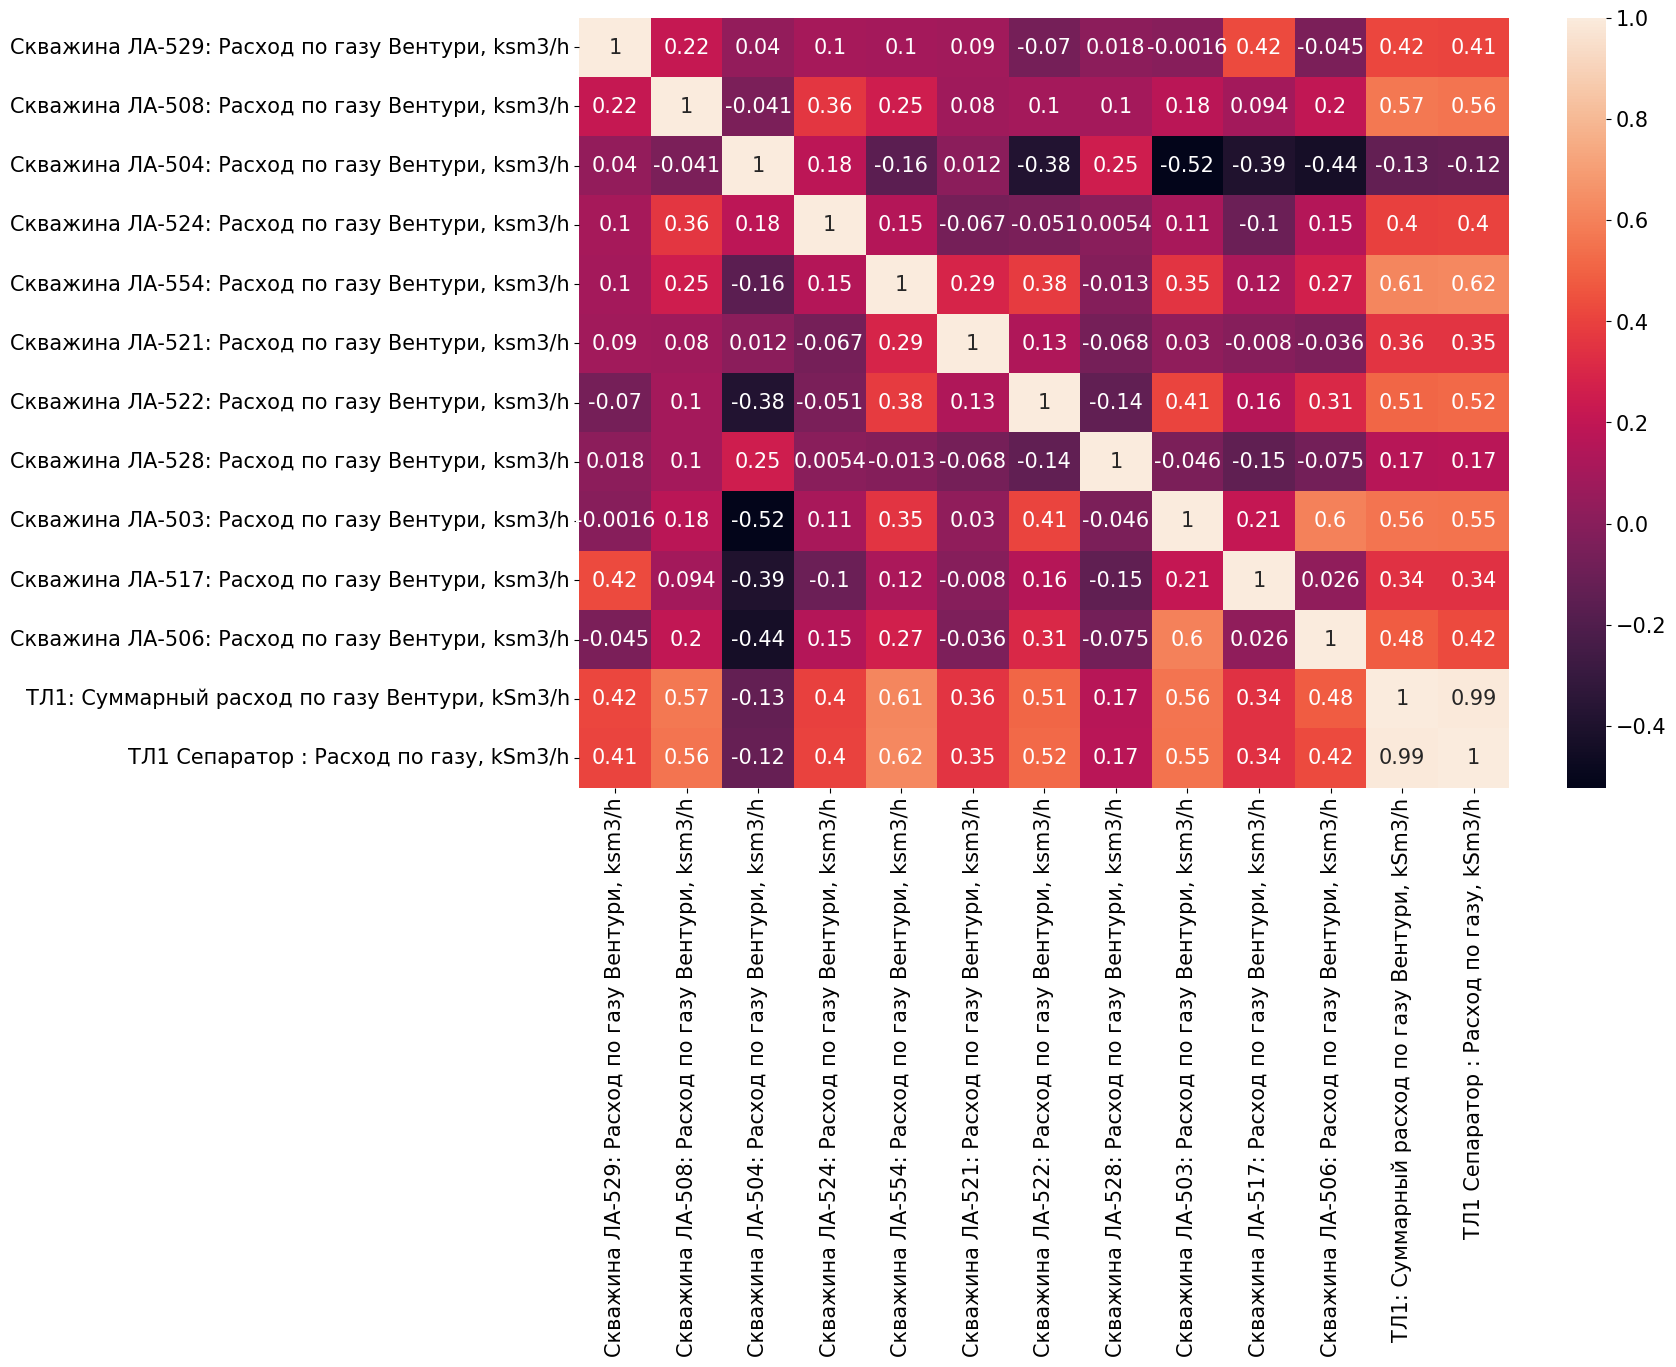

In [97]:
#plt.figure(figsize = (10, 8))
sns.heatmap(well_corr, annot = True)